Домашнее задание: классификация Симпсонов</br>
Student: Oleg Navolotsky / Наволоцкий Олег</br>
Stepik: https://stepik.org/users/2403189</br>
Kaggle: https://www.kaggle.com/olegnavolotsky

**Note**: reproducibility [depends on different things](https://pytorch.org/docs/stable/notes/randomness.html):
>Completely reproducible results are not guaranteed across PyTorch releases, individual commits, or different platforms. Furthermore, results may not be reproducible between CPU and GPU executions, even when using identical seeds.

Some used software versions:
 - Pytorch 1.7.0
 - torchvision 0.8.1
 - Python 3.8.3 (default, Jul  2 2020, 17:30:36) \[MSC v.1916 64 bit (AMD64)] :: Anaconda, Inc. on win32
 - NVIDIA Driver 456.71
 - NVIDIA CUDA 11.1
 - Windows 10 Pro 1909, build 18363.535

Hardware:
 - i5 2500 8 gb
 - GTX 1060 6 gb

In [ ]:
# Домашнее задание: классификация Симпсонов</br>
# Student: Oleg Navolotsky / Наволоцкий Олег</br>
# Stepik: https://stepik.org/users/2403189</br>
# Kaggle: https://www.kaggle.com/olegnavolotsky

# **Note**: reproducibility [depends on different things](https://pytorch.org/docs/stable/notes/randomness.html):
# >Completely reproducible results are not guaranteed across PyTorch releases, individual commits, or different platforms. Furthermore, results may not be reproducible between CPU and GPU executions, even when using identical seeds.

# Some used software versions:
# - Pytorch 1.7.0
# - torchvision 0.8.1
# - Python 3.8.3 (default, Jul  2 2020, 17:30:36) \[MSC v.1916 64 bit (AMD64)] :: Anaconda, Inc. on win32
# - NVIDIA Driver 456.71
# - NVIDIA CUDA 11.1
# - Windows 10 Pro 1909, build 18363.535

# Hardware:
# - i5 2500 8 gb
# - GTX 1060 6 gb

In [ ]:
import os
import random

import numpy as np
import torch
import torchvision

SEED = 0

def enable_reproducibility(seed=SEED, raise_if_no_deterministic=True):
    # https://pytorch.org/docs/stable/notes/randomness.html#avoiding-nondeterministic-algorithms
    if raise_if_no_deterministic:
        torch.set_deterministic(True)

    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"

In [ ]:
from pathlib import Path

HOW_MANY_DATA_TO_TAKE = None

DEVICE = torch.device('cuda')
NUM_WORKERS = 0

# Dataset parameters
TRAIN_DIR = Path("train/simpsons_dataset")
TEST_DIR = Path("testset/testset")
LABELS_PATH = Path("le_dump.pickle")
DATASET_IMAGE_CHANNELS_MEAN = [0.485, 0.456, 0.406]
DATASET_IMAGE_CHANNELS_STD_DEV = [0.229, 0.224, 0.225]
IMG_EXT = 'jpg'

RESCALE_SIZE = 224

# Training parameters
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 2 ** 9  #2 ** 10
VALIDATION_SIZE = 0.25

In [ ]:
import os
import pickle
from typing import Literal, List, get_args, Optional, Union, Iterable

from sklearn.preprocessing import LabelEncoder
from torchvision.datasets.folder import pil_loader
from torch.utils.data import Dataset


def get_label_encoder(files: Optional[Union[List[str], List[Path]]]=None, dump_path="le_dump.pickle"):
    if files is not None:
        if isinstance(files[0], str):
            labels = [os.path.basename(os.path.dirname(os.path.abspath(file))) for file in files]
        else:
            labels = [path.absolute().parent.name for path in files]
        label_encoder = LabelEncoder()
        label_encoder.fit(labels)
        dump_path = os.path.abspath(dump_path)
        os.makedirs(os.path.dirname(dump_path), exist_ok=True)
        with open(dump_path, 'wb') as dump_file:
            pickle.dump(label_encoder, dump_file)
    else:
        dump_path = os.path.abspath(dump_path)
        if not os.path.exists(dump_path):
            raise ValueError("`dump_path` must exist if `files` was not given")
        with open(dump_path, 'rb') as dump_file:
            label_encoder = pickle.load(dump_file)
    return label_encoder


DataMode = Literal['train', 'val', 'test']
DATA_MODES = get_args(DataMode)


class ImageClassDirectoriesDataset(Dataset):
    def __init__(self, files: List[Path], mode: DataMode, labels: Union[Iterable[str], LabelEncoder], transform=None):
        if mode not in DATA_MODES:
            raise ValueError(f"{mode} is not correct; correct modes: {DATA_MODES}")
        super().__init__()
        self.mode = mode
        self.files = sorted(os.path.abspath(file) for file in files)
        self.len_ = len(self.files)
        self.labels = labels if isinstance(labels, LabelEncoder) else list(labels)
        self.transform = transform

    def __len__(self):
        return self.len_

    def __getitem__(self, index):
        file = self.files[index]
        x = pil_loader(file)
        x = self.transform(x)
        if self.mode == 'test':
            return x, os.path.basename(file)
        else:
            label = os.path.basename(os.path.dirname(self.files[index]))
            if isinstance(self.labels, LabelEncoder):
                y = self.labels.transform([label]).item()
            else:
                y = self.labels.index(label)
            return x, y

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.' + IMG_EXT)))[:HOW_MANY_DATA_TO_TAKE]
test_files = sorted(list(TEST_DIR.rglob('*.' + IMG_EXT)))[:HOW_MANY_DATA_TO_TAKE]

from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
CLASSES_NUM = len(np.unique(train_val_labels))

# when shuffle=True and random_state=None,
# uses numpy.random.RandomState by default
enable_reproducibility()
train_files, val_files = train_test_split(
    train_val_files, test_size=VALIDATION_SIZE,
    stratify=train_val_labels, shuffle=True)

In [ ]:
from enum import Enum

from matplotlib import pyplot as plt
from torch import nn
from tqdm.notebook import tqdm, trange

class TrainType(Enum):
    TRAIN = "train"
    FULL = "full"

    def __str__(self):
        return self.value.lower()


MODEL_FILENAME_FMT = "{model_name}.{train_type}.{device_type}.pt"
MODEL_STORAGE_DIR = "./trained_models"

def save_model(model, optimizer, epoch, loss, model_name, path='.', lr_scheduler=None, metrics=None):
    state = {
        'model_name': model_name,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'lr_scheduler_state': None if lr_scheduler is None else lr_scheduler.state_dict(),
        'epoch': epoch,
        'loss': loss,
        'metrics': metrics
    }
    directory = os.path.dirname(os.path.abspath(path))
    os.makedirs(directory, exist_ok=True)
    torch.save(state, path)

def load_model_state_and_info(model_name, train_type, device_type):
    path = os.path.join(
        MODEL_STORAGE_DIR,
        MODEL_FILENAME_FMT.format(
            model_name=model_name,
            train_type=train_type,
            device_type=device_type
        )
    )
    return torch.load(path)

def show_plots(train_loss, train_metrics, val_loss, val_metrics, model_name=""):
    plt.figure(figsize=(15, 9))
    plt.plot(np.arange(1, len(train_loss) + 1), train_loss, label="train_loss")
    plt.plot(np.arange(1, len(val_loss) + 1), val_loss, label="val_loss")
    best_epoch = np.argmin(val_loss) + 1
    plt.axvline(best_epoch, color='r', label="best epoch by loss")
    plt.legend(loc='best')
    plt.title(model_name)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    
    plt.figure(figsize=(15, 9))
    for name, values in train_metrics.items():
        plt.plot(np.arange(1, len(values) + 1), values, label="train_{}".format(name))
    for name, values in val_metrics.items():
        plt.plot(np.arange(1, len(values) + 1), values, label="val_{}".format(name))
        best_epoch = np.argmax(values) + 1
        plt.axvline(best_epoch, color='r', label="best epoch by {}".format(name))
    plt.legend(loc='best')
    plt.title(model_name)
    plt.xlabel("epoch")
    plt.ylabel("metric")
    plt.show()

def print_best_epoch(metric_values, metric_name='metric', type: Optional[Literal['max', 'min']]='max', model_name='model'):
    if type == 'max':
        func = np.argmax
    elif type == 'min':
        func == np.argmin
    else:
        raise ValueError("`type` must be 'min' or 'max'")
    epoch = func(metric_values)
    best_metric_value = metric_values[epoch]
    epoch += 1
    print("{}: best {} value {} on {} epoch.".format(model_name, metric_name, best_metric_value, epoch))

def epoch_train_stage(model, data_loader, criterion, optimizer, device):
    # total = 0
    loss_sum = 0
    y_true = []
    y_pred = []
    was_training = model.training
    model.train()
    for data, labels in tqdm(data_loader, desc="train batches", leave=False):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        # total += output.shape[0]
        pred = output.argmax(1)
        y_true.append(labels)
        y_pred.append(pred)
    with torch.no_grad():
        y_true = torch.cat(y_true)
        y_pred = torch.cat(y_pred)
    model.train(was_training)
    return loss_sum / len(data_loader), y_true, y_pred


def epoch_val_stage(model, data_loader, criterion, device):
    # total = 0
    loss_sum = 0
    y_true = []
    y_pred = []
    was_training = model.training
    model.eval()
    with torch.no_grad():
        for data, labels in tqdm(data_loader, desc="val batches", leave=False):
            data, labels = data.to(device), labels.to(device)
            output = model(data)
            loss = criterion(output, labels)

            loss_sum += loss.item()
            # total += data.shape[0]
            pred = output.argmax(1)
            y_true.append(labels)
            y_pred.append(pred)

        y_true = torch.cat(y_true)
        y_pred = torch.cat(y_pred)

    model.train(was_training)
    return loss_sum / len(data_loader), y_true, y_pred


def train_model(
        model, train_loader, val_loader, criterion, optimizer, epochs, device,
        metrics, main_metric_name=None, save_best=False, model_name=None, logs_dir=MODEL_STORAGE_DIR, lr_scheduler=None):
    if model_name is None:
        model_name = model.__class__.__name__
    if not isinstance(metrics, dict):
        metrics = {metric.__name__: metric for metric in metrics}
    if save_best and main_metric_name is None:
        raise ValueError("You should set `main_metric_name` when `save_best` is True")
    if main_metric_name not in metrics:
        raise ValueError("`main_metric_name` \"{}\" not found in `metrics`".format(main_metric_name))

    train_losses = []
    train_metrics = {name: [] for name in metrics}
    val_losses = []
    val_metrics = {name: [] for name in metrics}
    best_epoch = -1
    history = [
        train_losses,
        train_metrics,
        val_losses,
        val_metrics,
    ]
    model = model.to(device)
    best_metric_value = None
    with trange(1, epochs + 1, desc="epochs") as pbar:
        for i in pbar:
            train_loss, *train_ytp = epoch_train_stage(model, train_loader, criterion, optimizer, device)
            train_losses.append(train_loss)
            for name, metric in metrics.items():
                train_metrics[name].append(metric(*train_ytp))
            val_loss, *val_ytp = epoch_val_stage(model, val_loader, criterion, device)
            if lr_scheduler is not None:
                lr_scheduler.step()
            val_losses.append(val_loss)
            for name, metric in metrics.items():
                val_metrics[name].append(metric(*val_ytp))
            if save_best and (best_metric_value is None or best_metric_value < val_metrics[main_metric_name][-1]):
                best_metric_value = val_metrics[main_metric_name][-1]
                model_filename = MODEL_FILENAME_FMT.format(
                    model_name=model_name, train_type=TrainType.TRAIN, device_type=device.type)
                save_model(
                    model, optimizer, i, val_loss,
                    model_name=model_name,
                    path=os.path.join(logs_dir, model_filename),
                    lr_scheduler=lr_scheduler, metrics={name: value_list[-1] for name, value_list in val_metrics.items()})
            pbar.set_postfix(
                t_loss=train_loss, v_loss=val_loss,
                **{"t_" + name: value_list[-1] for name, value_list in train_metrics.items()},
                **{"v_" + name: value_list[-1] for name, value_list in val_metrics.items()})
    return history

def refit(
        model, data_loader, criterion, optimizer, epochs, device,
        metrics, main_metric_name=None, save_best=False, model_name=None, logs_dir=MODEL_STORAGE_DIR, lr_scheduler=None):
    if model_name is None:
        model_name = model.__class__.__name__
    if not isinstance(metrics, dict):
        metrics = {metric.__name__: metric for metric in metrics}
    if save_best and main_metric_name is None:
        raise ValueError("You should set `main_metric_name` when `save_best` is True")
    if main_metric_name not in metrics:
        raise ValueError("`main_metric_name` \"{}\" not found in `metrics`".format(main_metric_name))

    train_losses = []
    train_metrics = {name: [] for name in metrics}
    best_epoch = -1
    history = [
        train_losses,
        train_metrics
    ]
    model = model.to(device)
    best_metric_value = None
    with trange(1, epochs + 1, desc="epochs") as pbar:
        for i in pbar:
            train_loss, *train_ytp = epoch_train_stage(model, data_loader, criterion, optimizer, device)
            train_losses.append(train_loss)
            for name, metric in metrics.items():
                train_metrics[name].append(metric(*train_ytp))
            if lr_scheduler is not None:
                lr_scheduler.step()
            if save_best and (best_metric_value is None or best_metric_value < train_metrics[main_metric_name][-1]):
                best_metric_value = train_metrics[main_metric_name][-1]
                model_filename = MODEL_FILENAME_FMT.format(
                    model_name=model_name, train_type=TrainType.FULL, device_type=device.type)
                save_model(
                    model, optimizer, i, train_loss,
                    model_name=model_name,
                    path=os.path.join(logs_dir, model_filename),
                    lr_scheduler=lr_scheduler, metrics={name: value_list[-1] for name, value_list in train_metrics.items()})
            pbar.set_postfix(
                t_loss=train_loss,
                **{"t_" + name: value_list[-1] for name, value_list in train_metrics.items()})
    return history


def predict(model, test_loader, device):
    was_training = model.training
    model.eval()
    true_labels = []
    logits = []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            logits.append(outputs)
            true_labels.append(y)
        true_labels = torch.cat(true_labels)
        probs = nn.functional.softmax(torch.cat(logits), dim=-1)
        labels_probs, labels = torch.max(probs, dim=-1)
    model.train(was_training)
    return true_labels.cpu().numpy(), labels.cpu().numpy(), labels_probs.cpu().numpy()

def predict_unknown(model, test_loader, device):
    was_training = model.training
    model.eval()
    samples_ids = []
    logits = []
    with torch.no_grad():
        for x, batch_samples_ids in test_loader:
            x = x.to(device)
            outputs = model(x)
            logits.append(outputs)
            samples_ids.append(batch_samples_ids)    
        samples_ids = np.concatenate(samples_ids)
        probs = nn.functional.softmax(torch.cat(logits), dim=-1)
        labels_probs, labels = torch.max(probs, dim=-1)
    model.train(was_training)
    return samples_ids, labels.cpu().numpy(), labels_probs.cpu().numpy()

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms

if os.path.exists(LABELS_PATH):
    label_encoder = get_label_encoder(dump_path=LABELS_PATH)
else:
    label_encoder = get_label_encoder(train_val_files, dump_path=LABELS_PATH)

default_transform = transforms.Compose([
    transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        DATASET_IMAGE_CHANNELS_MEAN, DATASET_IMAGE_CHANNELS_STD_DEV)
])

from PIL.Image import Image

def pad_to_square(image):
    if isinstance(image, Image):
        w, h = image.size
    else:
        *_, h, w = image.shape
    if h > w:
        top = bottom = 0
        diff = h - w
        left = diff // 2
        right = diff - left
    elif h < w:
        left = right = 0
        diff = w - h
        top = diff // 2
        bottom = diff - top
    else:
        return image
    return transforms.functional.pad(image, (left, top, right, bottom))

augmentation_transform = transforms.Compose([
    pad_to_square,
    transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        DATASET_IMAGE_CHANNELS_MEAN, DATASET_IMAGE_CHANNELS_STD_DEV)
])

from sklearn.metrics import f1_score

def mean_f1(y_true, y_pred):
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy()
    return f1_score(y_true, y_pred, average='macro')

USED_METRIC_FUNC = mean_f1
USED_METRIC_NAME = 'mean_f1'

In [ ]:
import pandas as pd


def save_results(samples_ids, predicted_labels, label_encoder, filename):
    decoded_labels = label_encoder.inverse_transform(predicted_labels)
    df = pd.DataFrame({'Id': samples_ids, 'Expected': decoded_labels})
    df.to_csv(filename, index=False)

# SimpleCnn

In [ ]:
from torch import nn
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.flatten(start_dim=1)
        logits = self.out(x)
        return logits

SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_features=42, bias=True)


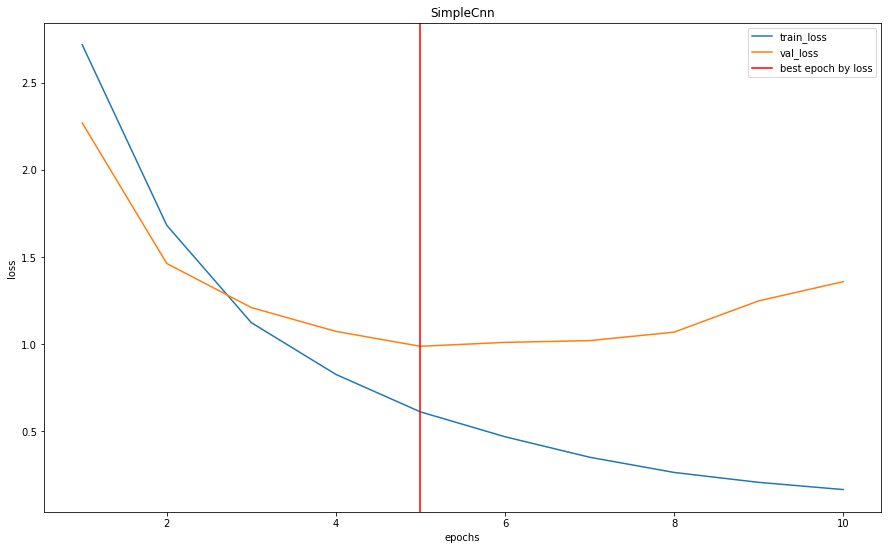

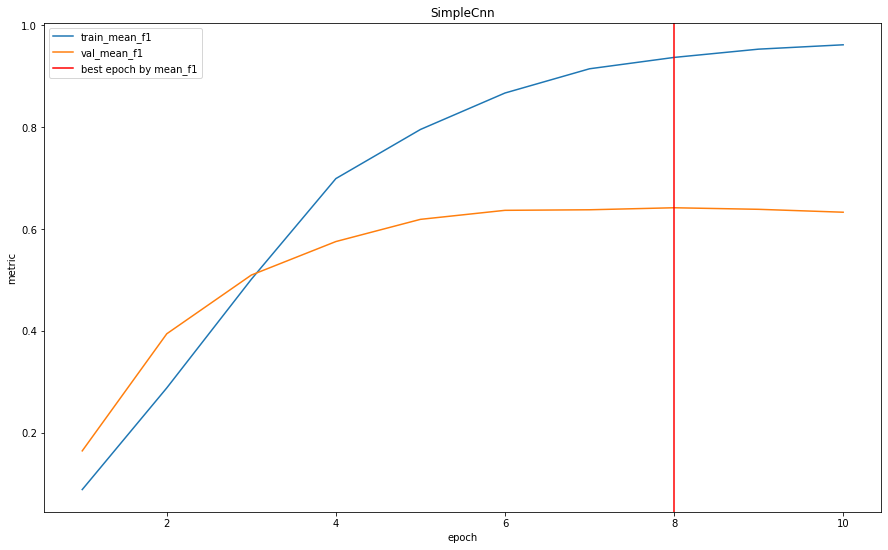

SimpleCnn: best mean_f1 value 0.6417236539349029 on 8 epoch.


In [ ]:
train_transform = val_transform = default_transform
train_dataset = ImageClassDirectoriesDataset(
    train_files, mode='train', labels=label_encoder, transform=train_transform)
val_dataset = ImageClassDirectoriesDataset(
    val_files, mode='val', labels=label_encoder, transform=val_transform)

SimpleCnn_batch_size = 64
SimpleCnn_epochs = 10

enable_reproducibility()
train_loader = DataLoader(
    train_dataset, batch_size=SimpleCnn_batch_size,
    shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(
    val_dataset, batch_size=TEST_BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS)

criterion = nn.CrossEntropyLoss()

torch.cuda.empty_cache()
simple_cnn = SimpleCnn(CLASSES_NUM).to(DEVICE)
optimizer = torch.optim.Adam(simple_cnn.parameters())
print(simple_cnn)

train_loss, train_metrics, val_loss, val_metrics = train_model(
    simple_cnn, train_loader, val_loader, criterion, optimizer, SimpleCnn_epochs, DEVICE,
    metrics=[USED_METRIC_FUNC], save_best=True, main_metric_name=USED_METRIC_NAME)

show_plots(
    train_loss, train_metrics, val_loss, val_metrics,
    model_name=simple_cnn.__class__.__name__)
print_best_epoch(
    val_metrics[USED_METRIC_NAME], metric_name=USED_METRIC_NAME,
    model_name=simple_cnn.__class__.__name__)


### Baseline из ноутбука, SimpleCnn, первый запуск, до перезапуска ноутбука:
SimpleCnn: best mean_f1 value 0.6417236539349029 on 8 epoch. Далее происходит переобучение (всего 10 эпох). Доля валидационной части: 25%.
### SimpleCnn, второй запуск, с теми же параметрами, результаты воспроизводимы:
SimpleCnn: best mean_f1 value 0.6417236539349029 on 8 epoch.
### SimpleCnn, после загрузки из файла лучшей эпохи результат на валидационном датасете тот же:

In [ ]:
torch.cuda.empty_cache()
simple_cnn = SimpleCnn(CLASSES_NUM).to(DEVICE)
state = load_model_state_and_info(
    simple_cnn.__class__.__name__, TrainType.TRAIN, DEVICE)
simple_cnn.load_state_dict(state['model_state'])
y_true, labels, probs = predict(simple_cnn, val_loader, DEVICE)
mean_f1(y_true, labels)

0.6417236539349029

## Переобучение с нуля на всём датасете (трейн + валидация) на 8 эпохах

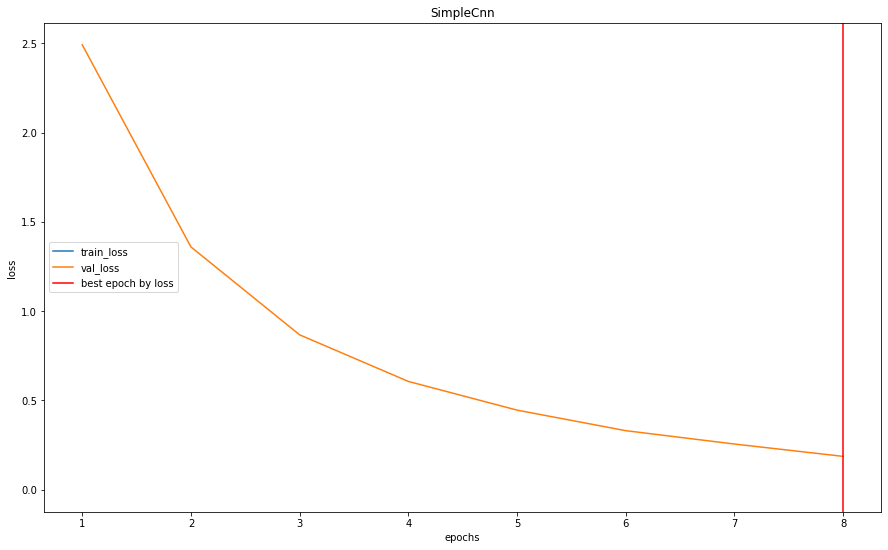

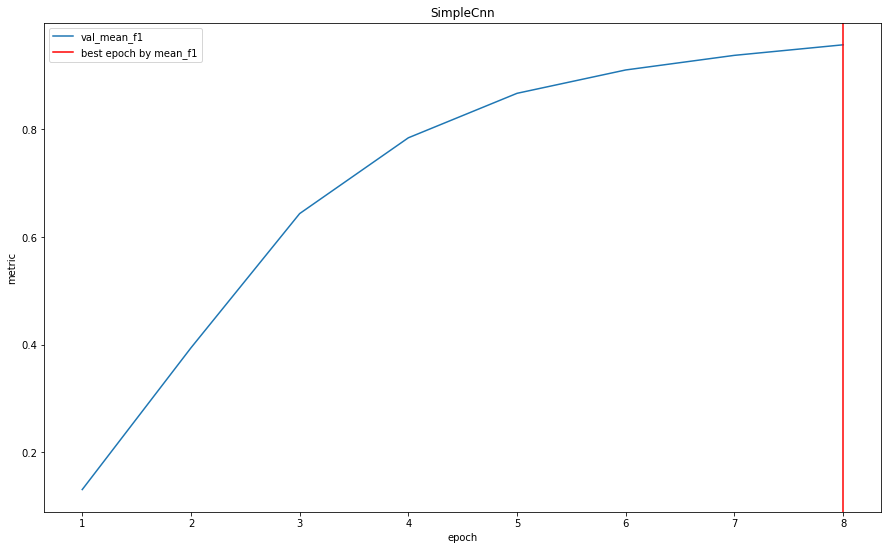

SimpleCnn: best mean_f1 value 0.9571128987416063 on 8 epoch.


In [ ]:
train_transform = val_transform = default_transform
train_val_dataset = ImageClassDirectoriesDataset(
    train_val_files, mode='train', labels=label_encoder, transform=train_transform)

SimpleCnn_batch_size = 64
SimpleCnn_epochs = 8

enable_reproducibility()
train_val_loader = DataLoader(
    train_val_dataset, batch_size=SimpleCnn_batch_size,
    shuffle=True, num_workers=NUM_WORKERS)

criterion = nn.CrossEntropyLoss()

torch.cuda.empty_cache()
simple_cnn_full = SimpleCnn(CLASSES_NUM).to(DEVICE)
optimizer = torch.optim.Adam(simple_cnn_full.parameters())

train_loss, train_metrics = refit(
    simple_cnn_full, train_val_loader, criterion, optimizer, SimpleCnn_epochs, DEVICE,
    metrics=[USED_METRIC_FUNC], save_best=True, main_metric_name=USED_METRIC_NAME)

show_plots(
    [0], {}, train_loss, train_metrics,
    model_name=simple_cnn_full.__class__.__name__)
print_best_epoch(
    train_metrics[USED_METRIC_NAME], metric_name=USED_METRIC_NAME,
    model_name=simple_cnn_full.__class__.__name__)

# Сохранение предсказаний переобученной модели для теста (#1 submit)

In [ ]:
test_dataset = ImageClassDirectoriesDataset(
    test_files, mode='test', labels=label_encoder, transform=default_transform)
test_loader = DataLoader(
    test_dataset, batch_size=TEST_BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS)

torch.cuda.empty_cache()
simple_cnn = SimpleCnn(CLASSES_NUM).to(DEVICE)
state = load_model_state_and_info(
    simple_cnn.__class__.__name__, TrainType.FULL, DEVICE)
simple_cnn.load_state_dict(state['model_state'])
samples_ids, labels, probs = predict_unknown(simple_cnn, test_loader, DEVICE)
save_results(samples_ids, labels, label_encoder, "simple_cnn_full_8_epochs.csv")

На Кагле скор 0.96811.

# SimpleCnn with batch normalization after activation in conv layers except last
Нормализация весов дает разделяющей гиперплоскости большую степень свободы. В семинаре [говорилось](https://www.youtube.com/watch?v=Y9a5EfqM7RM&t=1151), что расположение батчнорма — вопрос дискуссионный. Также есть [предположение](https://youtu.be/Y9a5EfqM7RM?t=1290), что расположение батчнорма перед перед выходным слоем может повлиять на предсказания в худшую сторону, т.к. именно по различиям на выходе из предпоследнего слоя происходит классификация.

Попробум сначала вариант батчнорма после активации (вход в следущий слой будет нормализованным) во всех сверточных слоях кроме последнего сверточного, т.к. он предпоследний во всей сети.

SimpleCnnBatchNormAfterReluInConvsExceptLast(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05,

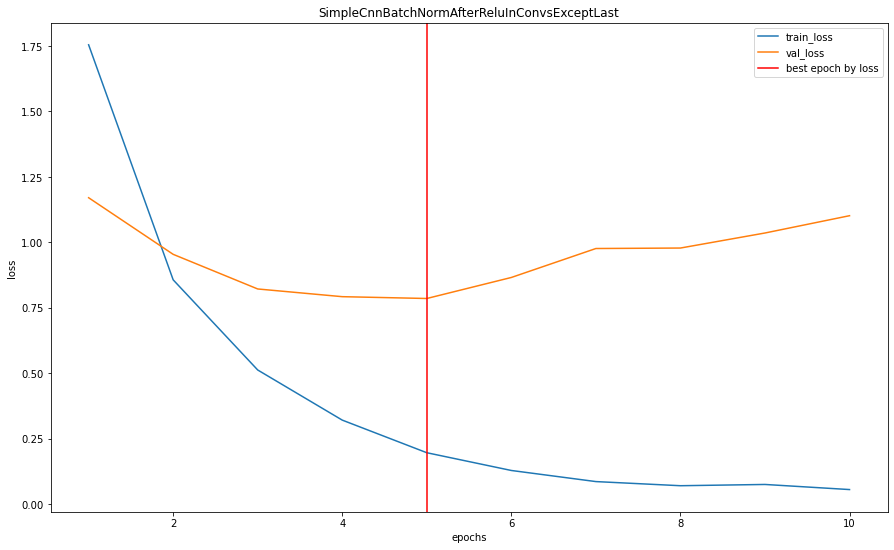

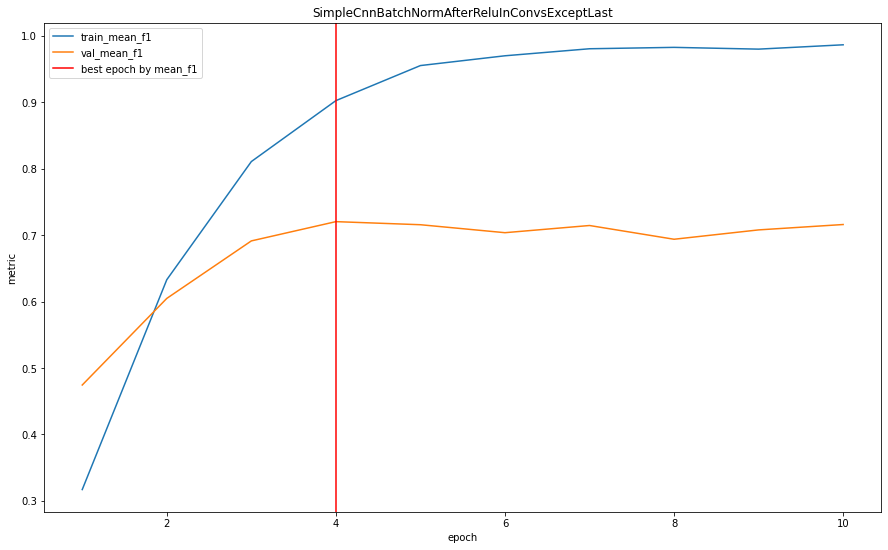

SimpleCnnBatchNormAfterReluInConvsExceptLast: best mean_f1 value 0.7202634028700753 on 4 epoch.


In [ ]:
class SimpleCnnBatchNormAfterReluInConvsExceptLast(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.flatten(start_dim=1)
        logits = self.out(x)
        return logits

NET_CLASS = SimpleCnnBatchNormAfterReluInConvsExceptLast

train_transform = val_transform = default_transform
train_dataset = ImageClassDirectoriesDataset(
    train_files, mode='train', labels=label_encoder, transform=train_transform)
val_dataset = ImageClassDirectoriesDataset(
    val_files, mode='val', labels=label_encoder, transform=val_transform)

TRAIN_BATCH_SIZE = 64
EPOCHS = 10

enable_reproducibility()
train_loader = DataLoader(
    train_dataset, batch_size=TRAIN_BATCH_SIZE,
    shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(
    val_dataset, batch_size=TEST_BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS)

criterion = nn.CrossEntropyLoss()

torch.cuda.empty_cache()
net = NET_CLASS(CLASSES_NUM).to(DEVICE)
optimizer = torch.optim.Adam(net.parameters())
print(net)

train_loss, train_metrics, val_loss, val_metrics = train_model(
    net, train_loader, val_loader, criterion, optimizer, EPOCHS, DEVICE,
    metrics=[USED_METRIC_FUNC], save_best=True, main_metric_name=USED_METRIC_NAME)

show_plots(
    train_loss, train_metrics, val_loss, val_metrics,
    model_name=net.__class__.__name__)
print_best_epoch(
    val_metrics[USED_METRIC_NAME], metric_name=USED_METRIC_NAME,
    model_name=net.__class__.__name__)


**Вывод**: с батчнормом после активации качество лучше и модель учится быстрее, чем без батчнорма.

# SimpleCnn with batch normalization before activation in conv layers except last
Теперь вариант с батчнормом перед активаций, опять же кроме предпоследнего слоя.

SimpleCnnBatchNormBeforeReluInConvsExceptLast(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, 

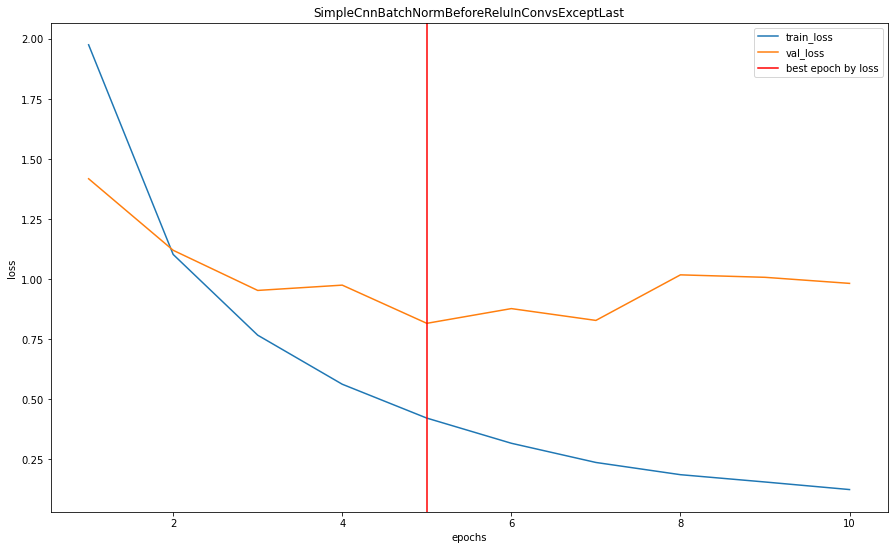

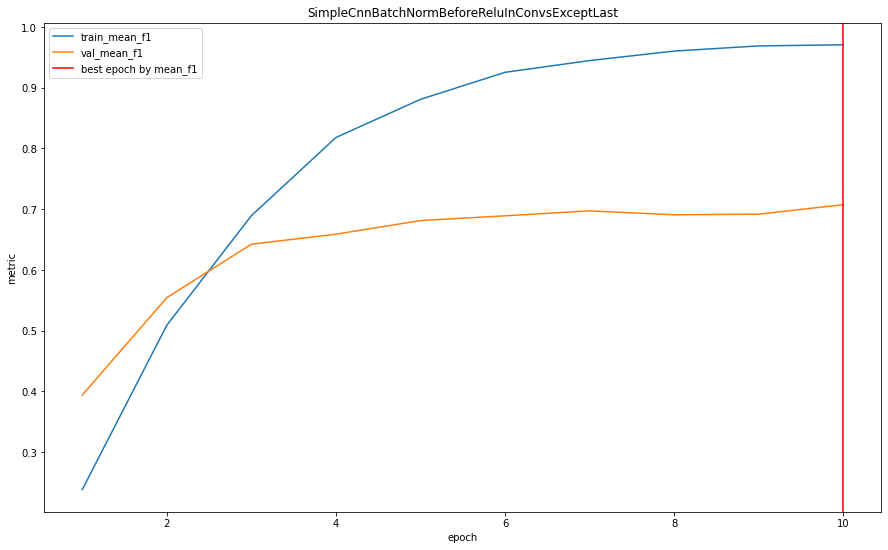

SimpleCnnBatchNormBeforeReluInConvsExceptLast: best mean_f1 value 0.7074123565098203 on 10 epoch.


In [ ]:
class SimpleCnnBatchNormBeforeReluInConvsExceptLast(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.flatten(start_dim=1)
        logits = self.out(x)
        return logits

NET_CLASS = SimpleCnnBatchNormBeforeReluInConvsExceptLast

train_transform = val_transform = default_transform
train_dataset = ImageClassDirectoriesDataset(
    train_files, mode='train', labels=label_encoder, transform=train_transform)
val_dataset = ImageClassDirectoriesDataset(
    val_files, mode='val', labels=label_encoder, transform=val_transform)

TRAIN_BATCH_SIZE = 64
EPOCHS = 10

enable_reproducibility()
train_loader = DataLoader(
    train_dataset, batch_size=TRAIN_BATCH_SIZE,
    shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(
    val_dataset, batch_size=TEST_BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS)

criterion = nn.CrossEntropyLoss()

torch.cuda.empty_cache()
net = NET_CLASS(CLASSES_NUM).to(DEVICE)
optimizer = torch.optim.Adam(net.parameters())
print(net)

train_loss, train_metrics, val_loss, val_metrics = train_model(
    net, train_loader, val_loader, criterion, optimizer, EPOCHS, DEVICE,
    metrics=[USED_METRIC_FUNC], save_best=True, main_metric_name=USED_METRIC_NAME)

show_plots(
    train_loss, train_metrics, val_loss, val_metrics,
    model_name=net.__class__.__name__)
print_best_epoch(
    val_metrics[USED_METRIC_NAME], metric_name=USED_METRIC_NAME,
    model_name=net.__class__.__name__)


**Вывод**: качество хуже и модель учится медленее, чем с батчнормом после активации.

# SimpleCnn with batch norm and two linears
Добавим дополнительный линейный слой и батчнорм после последнего сверточного.

SimpleCnnTwoLinears(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

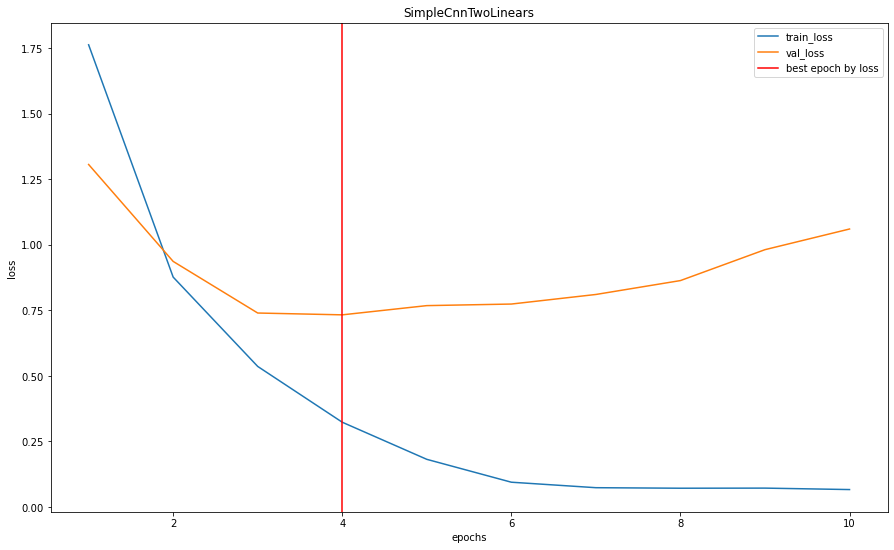

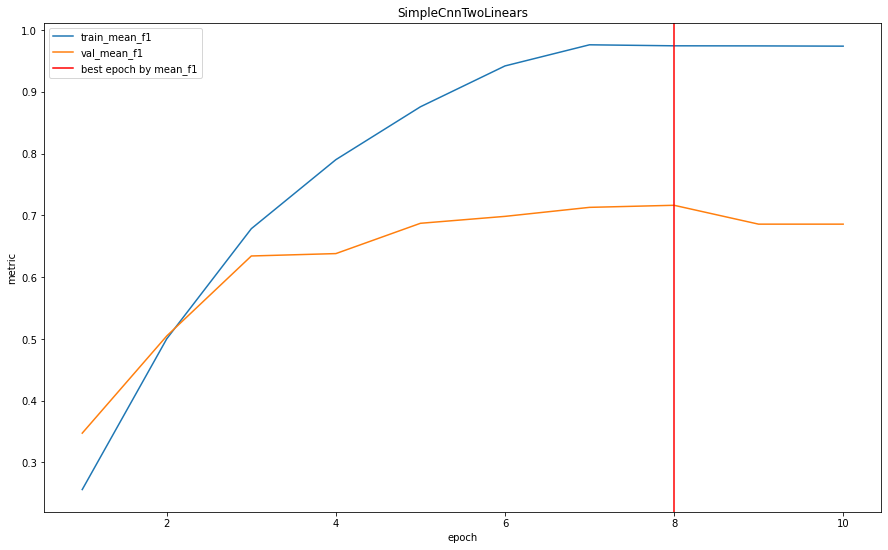

SimpleCnnTwoLinears: best mean_f1 value 0.7162679882026117 on 8 epoch.


In [ ]:
class SimpleCnnTwoLinears(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=2)
        )
        flatten_convs_output_size = 96 * 5 * 5
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=flatten_convs_output_size, out_features=64),
            nn.ReLU()
        )
        self.out = nn.Linear(in_features=64, out_features=n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.flatten(start_dim=1)

        x = self.fc1(x)
        logits = self.out(x)
        return logits

NET_CLASS = SimpleCnnTwoLinears

train_transform = val_transform = default_transform
train_dataset = ImageClassDirectoriesDataset(
    train_files, mode='train', labels=label_encoder, transform=train_transform)
val_dataset = ImageClassDirectoriesDataset(
    val_files, mode='val', labels=label_encoder, transform=val_transform)

TRAIN_BATCH_SIZE = 64
EPOCHS = 10

enable_reproducibility()
train_loader = DataLoader(
    train_dataset, batch_size=TRAIN_BATCH_SIZE,
    shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(
    val_dataset, batch_size=TEST_BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS)

criterion = nn.CrossEntropyLoss()

torch.cuda.empty_cache()
net = NET_CLASS(CLASSES_NUM).to(DEVICE)
optimizer = torch.optim.Adam(net.parameters())
print(net)

train_loss, train_metrics, val_loss, val_metrics = train_model(
    net, train_loader, val_loader, criterion, optimizer, EPOCHS, DEVICE,
    metrics=[USED_METRIC_FUNC], save_best=True, main_metric_name=USED_METRIC_NAME)

show_plots(
    train_loss, train_metrics, val_loss, val_metrics,
    model_name=net.__class__.__name__)
print_best_epoch(
    val_metrics[USED_METRIC_NAME], metric_name=USED_METRIC_NAME,
    model_name=net.__class__.__name__)


**Вывод**: модель стала учиться чуть хуже и в конце переобучается. Добавим регуляризации дропаутом.

# SimpleCnn with batch norm, two linears and dropout

Добавим дропаут первого линейного слоя с вероятостью по умолчанию, равной 0.5

SimpleCnnTwoLinearsDropout(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

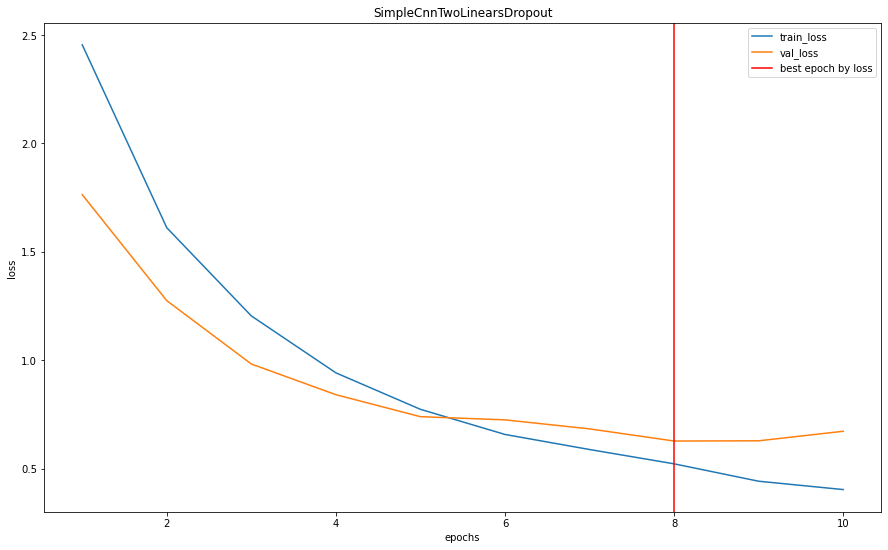

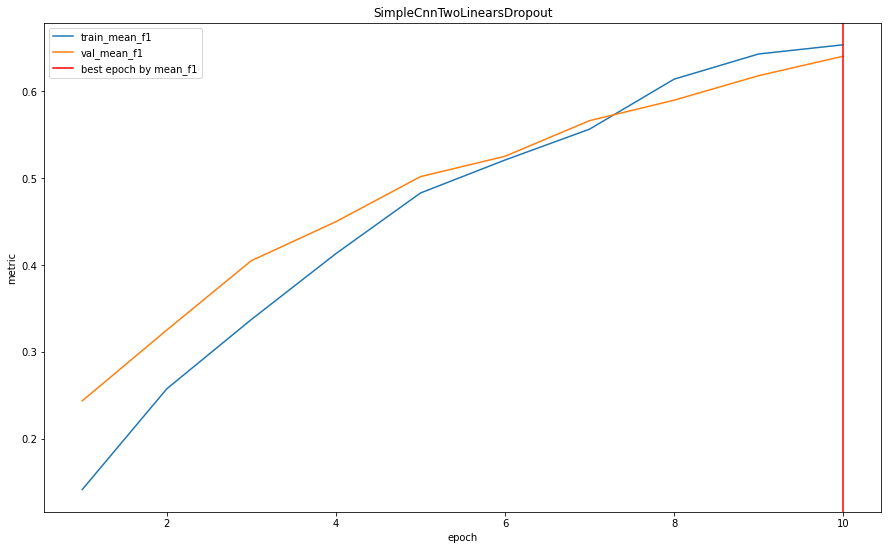

SimpleCnnTwoLinearsDropout: best mean_f1 value 0.6399779933627244 on 10 epoch.


In [ ]:
class SimpleCnnTwoLinearsDropout(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=2)
        )
        flatten_convs_output_size = 96 * 5 * 5
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=flatten_convs_output_size, out_features=64),
            nn.ReLU(),
            nn.Dropout()
        )
        self.out = nn.Linear(in_features=64, out_features=n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.flatten(start_dim=1)

        x = self.fc1(x)
        logits = self.out(x)
        return logits

NET_CLASS = SimpleCnnTwoLinearsDropout

train_transform = val_transform = default_transform
train_dataset = ImageClassDirectoriesDataset(
    train_files, mode='train', labels=label_encoder, transform=train_transform)
val_dataset = ImageClassDirectoriesDataset(
    val_files, mode='val', labels=label_encoder, transform=val_transform)

TRAIN_BATCH_SIZE = 64
EPOCHS = 10

enable_reproducibility()
train_loader = DataLoader(
    train_dataset, batch_size=TRAIN_BATCH_SIZE,
    shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(
    val_dataset, batch_size=TEST_BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS)

criterion = nn.CrossEntropyLoss()

torch.cuda.empty_cache()
net = NET_CLASS(CLASSES_NUM).to(DEVICE)
optimizer = torch.optim.Adam(net.parameters())
print(net)

train_loss, train_metrics, val_loss, val_metrics = train_model(
    net, train_loader, val_loader, criterion, optimizer, EPOCHS, DEVICE,
    metrics=[USED_METRIC_FUNC], save_best=True, main_metric_name=USED_METRIC_NAME)

show_plots(
    train_loss, train_metrics, val_loss, val_metrics,
    model_name=net.__class__.__name__)
print_best_epoch(
    val_metrics[USED_METRIC_NAME], metric_name=USED_METRIC_NAME,
    model_name=net.__class__.__name__)


10 эпох маловато, доучим на еще 10

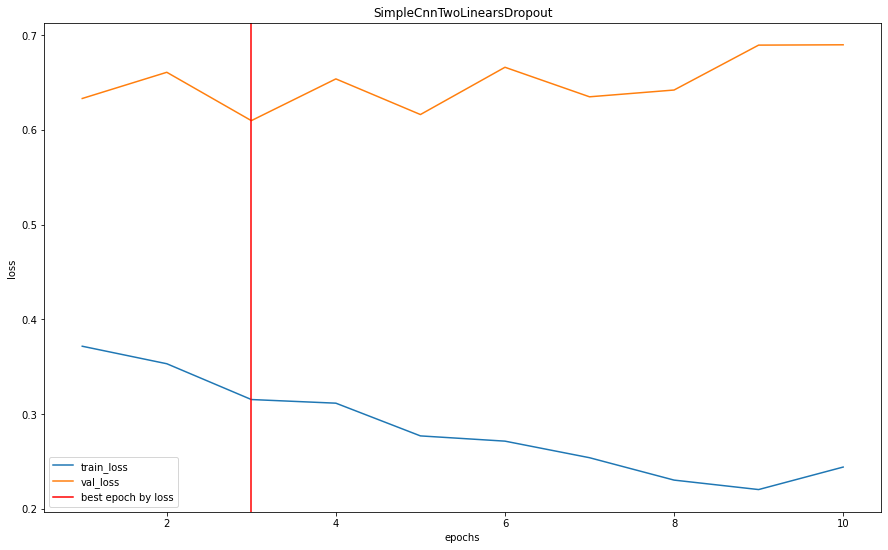

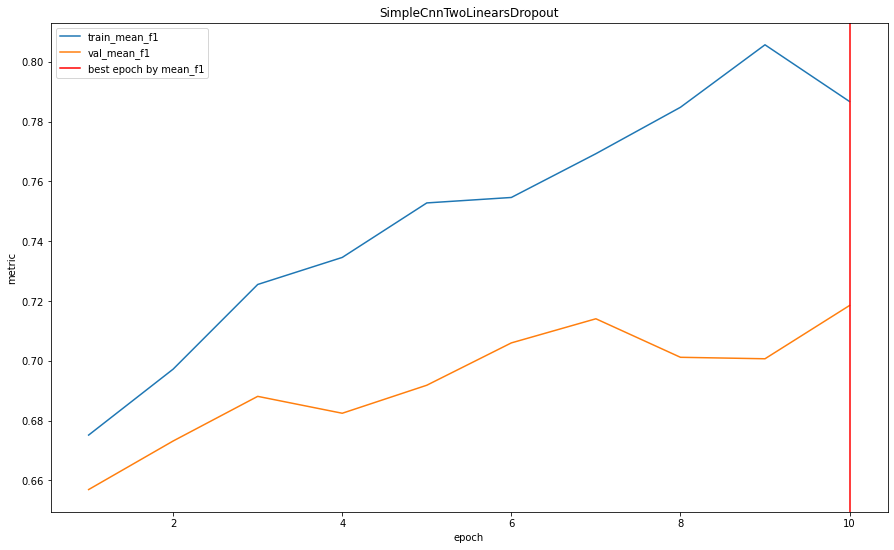

SimpleCnnTwoLinearsDropout: best mean_f1 value 0.7184952646123332 on 10 epoch.


In [ ]:
train_loss, train_metrics, val_loss, val_metrics = train_model(
    net, train_loader, val_loader, criterion, optimizer, EPOCHS, DEVICE,
    metrics=[USED_METRIC_FUNC], save_best=True, main_metric_name=USED_METRIC_NAME)

show_plots(
    train_loss, train_metrics, val_loss, val_metrics,
    model_name=net.__class__.__name__)
print_best_epoch(
    val_metrics[USED_METRIC_NAME], metric_name=USED_METRIC_NAME,
    model_name=net.__class__.__name__)

Качество не подросло до наилучшей к этому моменту модели SimpleCnnBatchNormAfterReluInConvsExceptLast. Увеличим размер батча до 128, а эпох поставим 10, обучим с нуля.

SimpleCnnTwoLinearsDropout(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

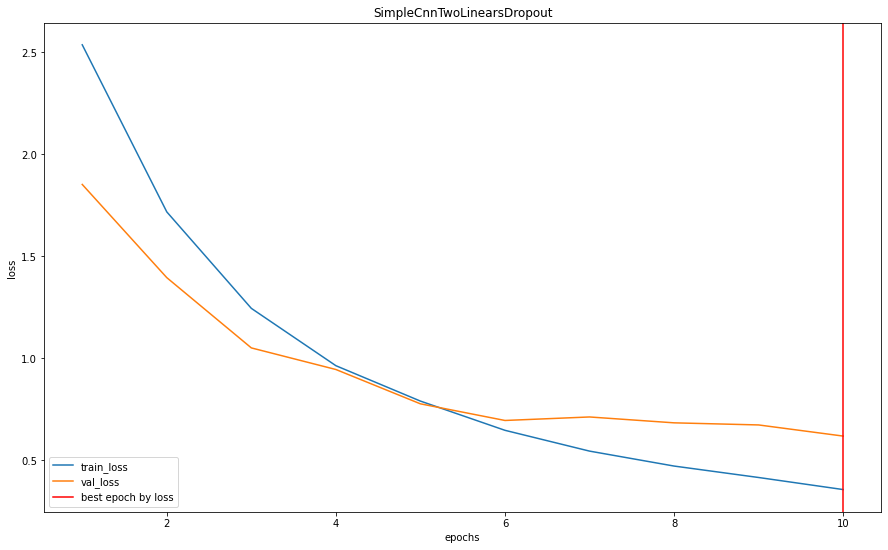

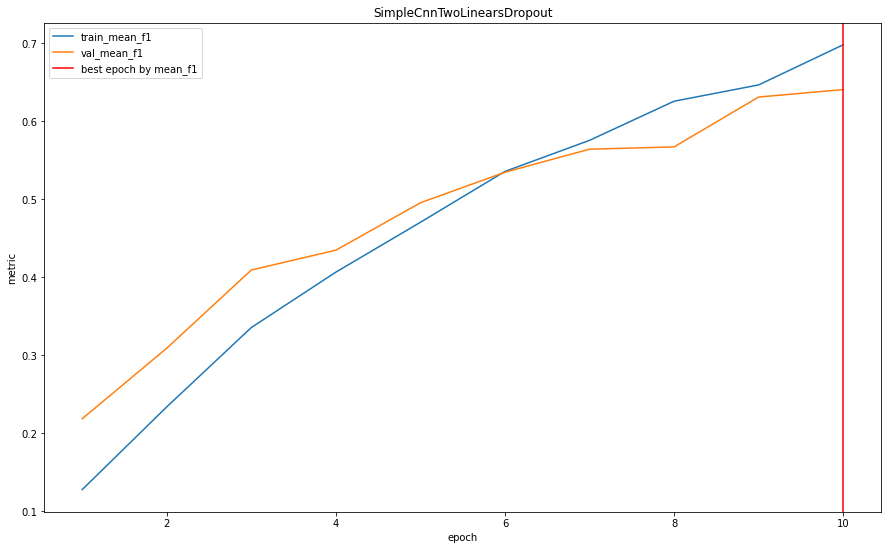

SimpleCnnTwoLinearsDropout: best mean_f1 value 0.6407261714884901 on 10 epoch.


In [ ]:
TRAIN_BATCH_SIZE = 128
EPOCHS = 10

enable_reproducibility()
train_loader = DataLoader(
    train_dataset, batch_size=TRAIN_BATCH_SIZE,
    shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(
    val_dataset, batch_size=TEST_BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS)

criterion = nn.CrossEntropyLoss()

torch.cuda.empty_cache()
net = NET_CLASS(CLASSES_NUM).to(DEVICE)
optimizer = torch.optim.Adam(net.parameters())
print(net)

train_loss, train_metrics, val_loss, val_metrics = train_model(
    net, train_loader, val_loader, criterion, optimizer, EPOCHS, DEVICE,
    metrics=[USED_METRIC_FUNC], save_best=True, main_metric_name=USED_METRIC_NAME)

show_plots(
    train_loss, train_metrics, val_loss, val_metrics,
    model_name=net.__class__.__name__)
print_best_epoch(
    val_metrics[USED_METRIC_NAME], metric_name=USED_METRIC_NAME,
    model_name=net.__class__.__name__)

Результат чуть лучше, чем на батче 64 и 10 эпохах, переобучение возникает на одну эпоху раньше: в 6-й вместо 7-й.

# #2 submit with SimpleCnnBatchNormAfterReluInConvsExceptLast learned on full dataset

SimpleCnnBatchNormAfterReluInConvsExceptLast, обучение на всем датасете (4 эпохи) затем предсказание на тесте.

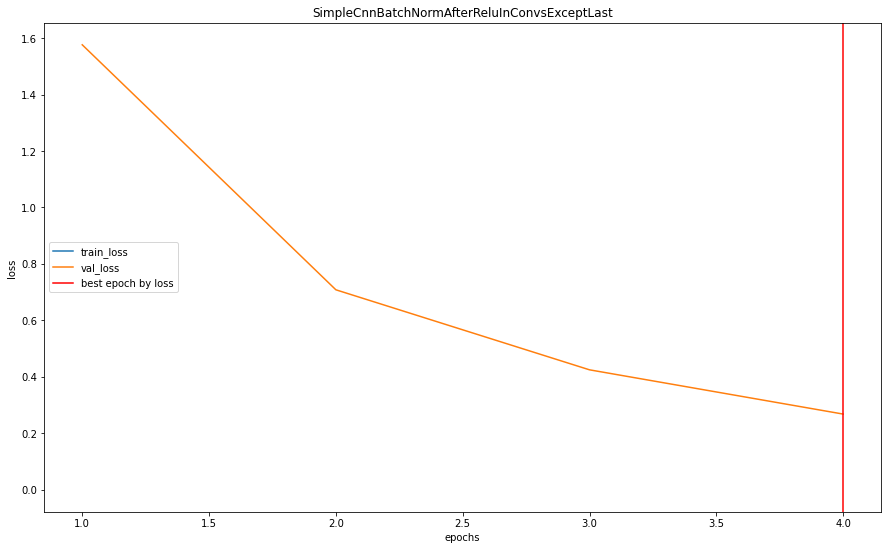

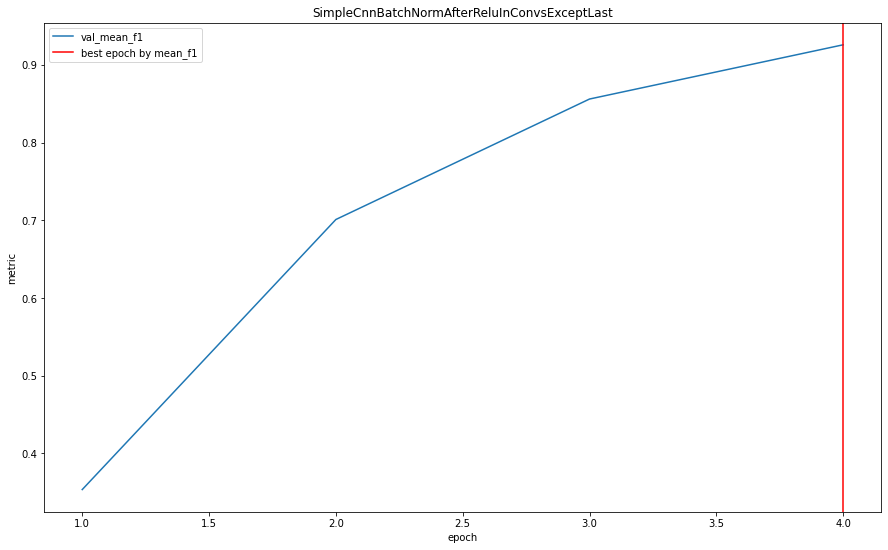

SimpleCnnBatchNormAfterReluInConvsExceptLast: best mean_f1 value 0.925741222426651 on 4 epoch.


In [ ]:
NET_CLASS = SimpleCnnBatchNormAfterReluInConvsExceptLast

train_transform = val_transform = default_transform
train_val_dataset = ImageClassDirectoriesDataset(
    train_val_files, mode='train', labels=label_encoder, transform=train_transform)

TRAIN_BATCH_SIZE = 64
EPOCHS = 4

enable_reproducibility()
train_val_loader = DataLoader(
    train_val_dataset, batch_size=TRAIN_BATCH_SIZE,
    shuffle=True, num_workers=NUM_WORKERS)

criterion = nn.CrossEntropyLoss()

torch.cuda.empty_cache()
net = NET_CLASS(CLASSES_NUM).to(DEVICE)
optimizer = torch.optim.Adam(net.parameters())

train_loss, train_metrics = refit(
    net, train_val_loader, criterion, optimizer, EPOCHS, DEVICE,
    metrics=[USED_METRIC_FUNC], save_best=True, main_metric_name=USED_METRIC_NAME)

show_plots(
    [0], {}, train_loss, train_metrics,
    model_name=net.__class__.__name__)
print_best_epoch(
    train_metrics[USED_METRIC_NAME], metric_name=USED_METRIC_NAME,
    model_name=net.__class__.__name__)

In [ ]:
NET_CLASS = SimpleCnnBatchNormAfterReluInConvsExceptLast

enable_reproducibility()
test_dataset = ImageClassDirectoriesDataset(
    test_files, mode='test', labels=label_encoder, transform=default_transform)
test_loader = DataLoader(
    test_dataset, batch_size=TEST_BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS)

torch.cuda.empty_cache()
samples_ids, labels, probs = predict_unknown(net, test_loader, DEVICE)
save_results(samples_ids, labels, label_encoder, "SimpleCnnBatchNormAfterReluInConvsExceptLast_full_4_epochs.csv")

На Кагле скор 0.94473.

# SimpleCnnBatchNormAfterReluInConvsIncludeLast

SimpleCnnBatchNormAfterReluInConvsIncludeLast(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05

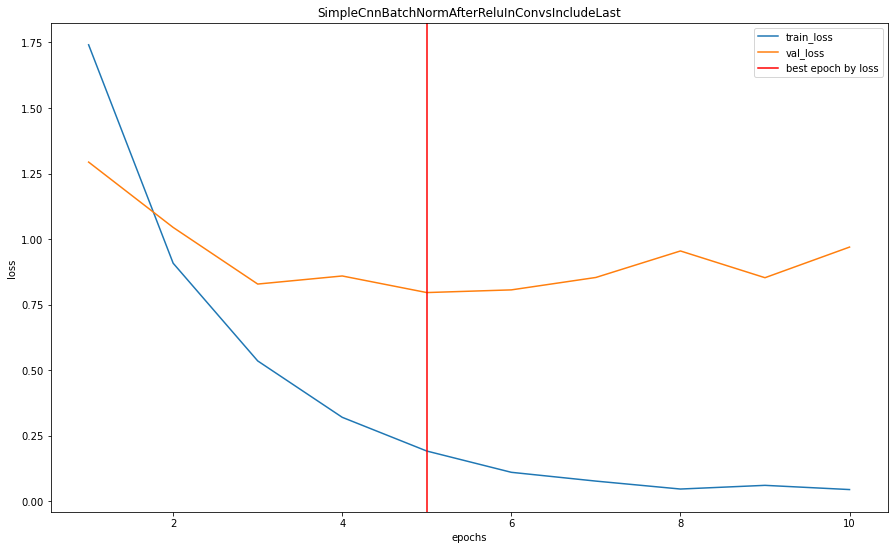

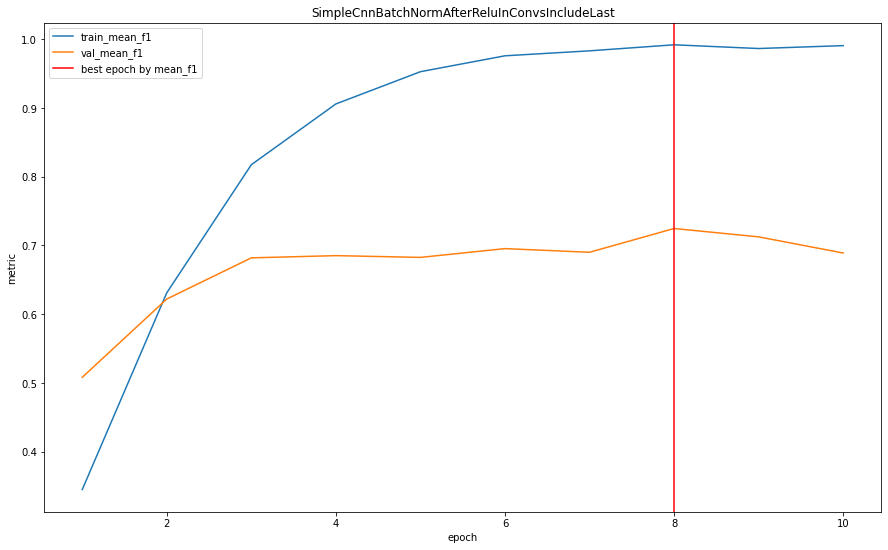

SimpleCnnBatchNormAfterReluInConvsIncludeLast: best mean_f1 value 0.724704363371754 on 8 epoch.


In [ ]:
class SimpleCnnBatchNormAfterReluInConvsIncludeLast(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.flatten(start_dim=1)
        logits = self.out(x)
        return logits

NET_CLASS = SimpleCnnBatchNormAfterReluInConvsIncludeLast

train_transform = val_transform = default_transform
train_dataset = ImageClassDirectoriesDataset(
    train_files, mode='train', labels=label_encoder, transform=train_transform)
val_dataset = ImageClassDirectoriesDataset(
    val_files, mode='val', labels=label_encoder, transform=val_transform)

TRAIN_BATCH_SIZE = 64
EPOCHS = 10

enable_reproducibility()
train_loader = DataLoader(
    train_dataset, batch_size=TRAIN_BATCH_SIZE,
    shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(
    val_dataset, batch_size=TEST_BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS)

criterion = nn.CrossEntropyLoss()

torch.cuda.empty_cache()
net = NET_CLASS(CLASSES_NUM).to(DEVICE)
optimizer = torch.optim.Adam(net.parameters())
print(net)

train_loss, train_metrics, val_loss, val_metrics = train_model(
    net, train_loader, val_loader, criterion, optimizer, EPOCHS, DEVICE,
    metrics=[USED_METRIC_FUNC], save_best=True, main_metric_name=USED_METRIC_NAME)

show_plots(
    train_loss, train_metrics, val_loss, val_metrics,
    model_name=net.__class__.__name__)
print_best_epoch(
    val_metrics[USED_METRIC_NAME], metric_name=USED_METRIC_NAME,
    model_name=net.__class__.__name__)


Результат хуже, чем без батчнорма на предпоследнем слое.

# SimpleCnn with different seed

SimpleCnnWithDifferentSeed42(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_featu

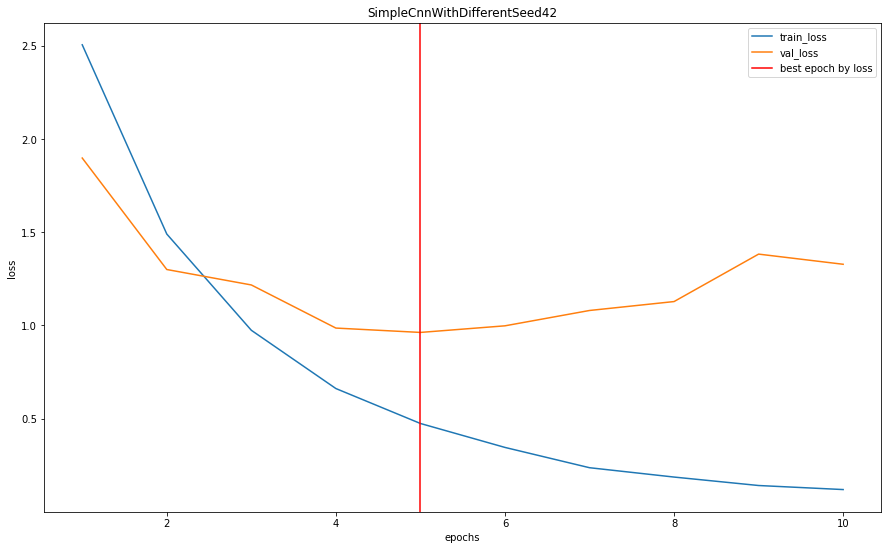

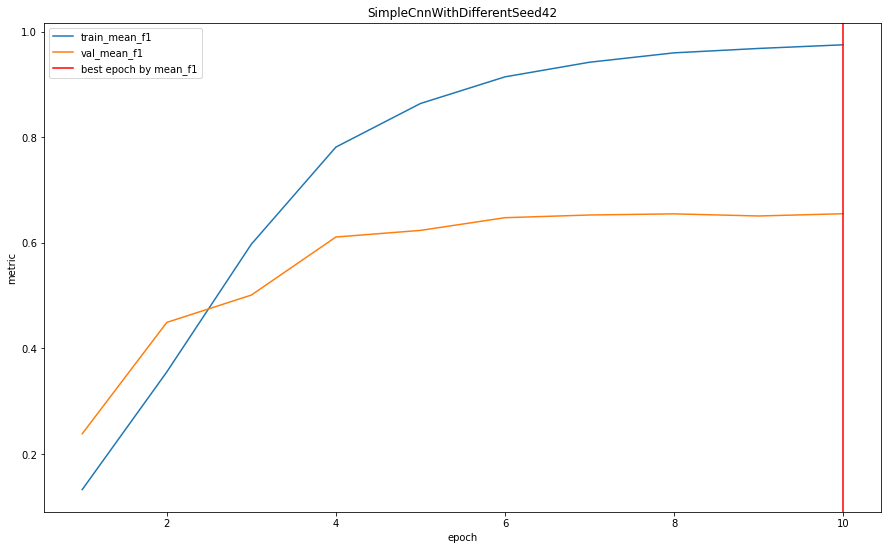

SimpleCnnWithDifferentSeed42: best mean_f1 value 0.6550782698698266 on 10 epoch.


In [ ]:
NET_CLASS = SimpleCnn
NET_CLASS.__name__ = "SimpleCnnWithDifferentSeed42"
NEW_SEED = 42

train_transform = val_transform = default_transform
train_dataset = ImageClassDirectoriesDataset(
    train_files, mode='train', labels=label_encoder, transform=train_transform)
val_dataset = ImageClassDirectoriesDataset(
    val_files, mode='val', labels=label_encoder, transform=val_transform)

TRAIN_BATCH_SIZE = 64
EPOCHS = 10

enable_reproducibility(seed=NEW_SEED)
train_loader = DataLoader(
    train_dataset, batch_size=TRAIN_BATCH_SIZE,
    shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(
    val_dataset, batch_size=TEST_BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS)

criterion = nn.CrossEntropyLoss()

torch.cuda.empty_cache()
net = NET_CLASS(CLASSES_NUM).to(DEVICE)
optimizer = torch.optim.Adam(net.parameters())
print(net)

train_loss, train_metrics, val_loss, val_metrics = train_model(
    net, train_loader, val_loader, criterion, optimizer, EPOCHS, DEVICE,
    metrics=[USED_METRIC_FUNC], save_best=True, main_metric_name=USED_METRIC_NAME)

show_plots(
    train_loss, train_metrics, val_loss, val_metrics,
    model_name=net.__class__.__name__)
print_best_epoch(
    val_metrics[USED_METRIC_NAME], metric_name=USED_METRIC_NAME,
    model_name=net.__class__.__name__)


# ResNet18, learning last layer at first, then all

Загружаем обученную ResNet18, заменяем последней слой и его обучаем (остальные замораживаем).

ResNet18PretrainedLearningOnlyLast8Epochs(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


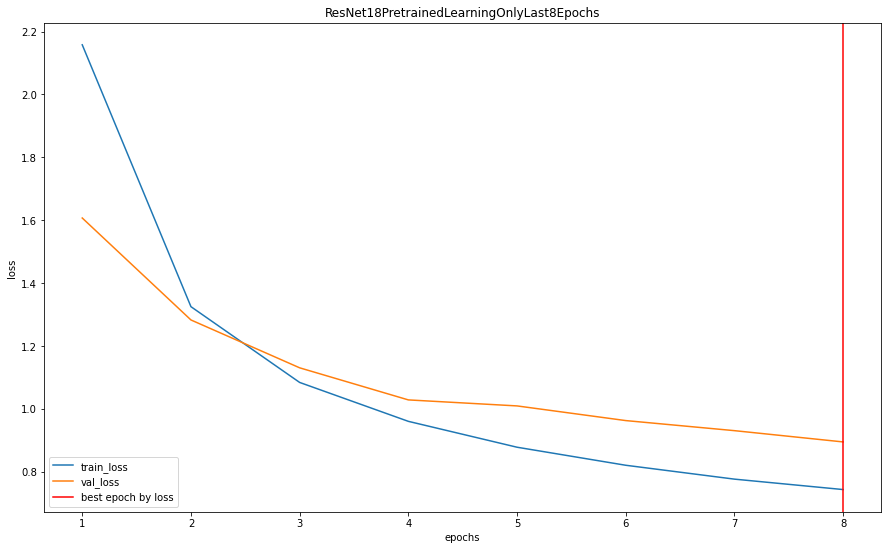

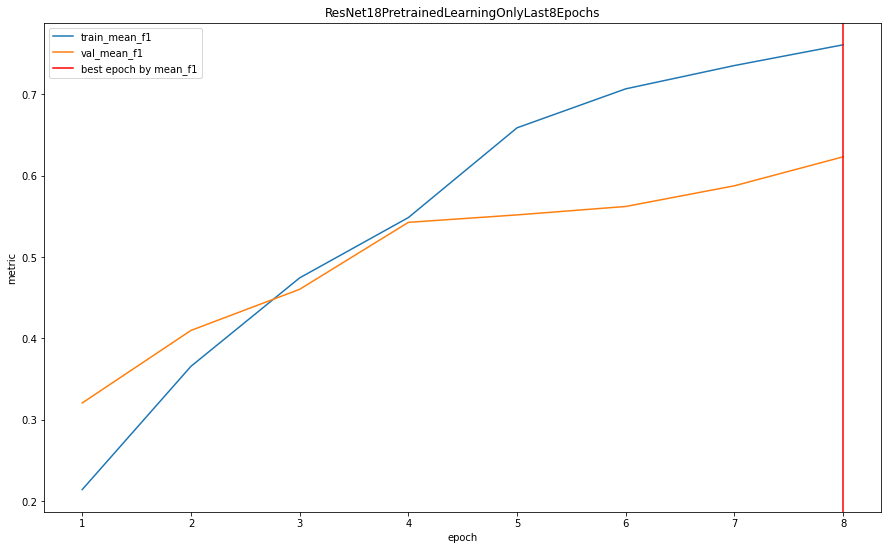

ResNet18PretrainedLearningOnlyLast8Epochs: best mean_f1 value 0.623001468807365 on 8 epoch.


In [ ]:
net = torchvision.models.resnet18(pretrained=True)

# замораживаем параметры (веса)
for param in net.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 512
# Заменяем Fully-Connected слой на наш линейный классификатор
enable_reproducibility()
net.fc = nn.Linear(num_features, CLASSES_NUM)

# Обучаем только классификатор
optimizer = torch.optim.Adam(net.fc.parameters())
NET_CLASS = net.__class__
NET_CLASS.__name__ = 'ResNet18PretrainedLearningOnlyLast8Epochs'

train_transform = val_transform = default_transform
train_dataset = ImageClassDirectoriesDataset(
    train_files, mode='train', labels=label_encoder, transform=train_transform)
val_dataset = ImageClassDirectoriesDataset(
    val_files, mode='val', labels=label_encoder, transform=val_transform)

TRAIN_BATCH_SIZE = 64
EPOCHS = 8

enable_reproducibility()
train_loader = DataLoader(
    train_dataset, batch_size=TRAIN_BATCH_SIZE,
    shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(
    val_dataset, batch_size=TEST_BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS)

criterion = nn.CrossEntropyLoss()

torch.cuda.empty_cache()
# net = NET_CLASS(CLASSES_NUM).to(DEVICE)
net = net.to(DEVICE)
# optimizer = torch.optim.Adam(net.parameters())
print(net)

train_loss, train_metrics, val_loss, val_metrics = train_model(
    net, train_loader, val_loader, criterion, optimizer, EPOCHS, DEVICE,
    metrics=[USED_METRIC_FUNC], save_best=True, main_metric_name=USED_METRIC_NAME)

show_plots(
    train_loss, train_metrics, val_loss, val_metrics,
    model_name=net.__class__.__name__)
print_best_epoch(
    val_metrics[USED_METRIC_NAME], metric_name=USED_METRIC_NAME,
    model_name=net.__class__.__name__)

Загружаем дообученную на 8 эпохах ResNet18 (только последний слой) и затем обучаем уже все сверточные слои:

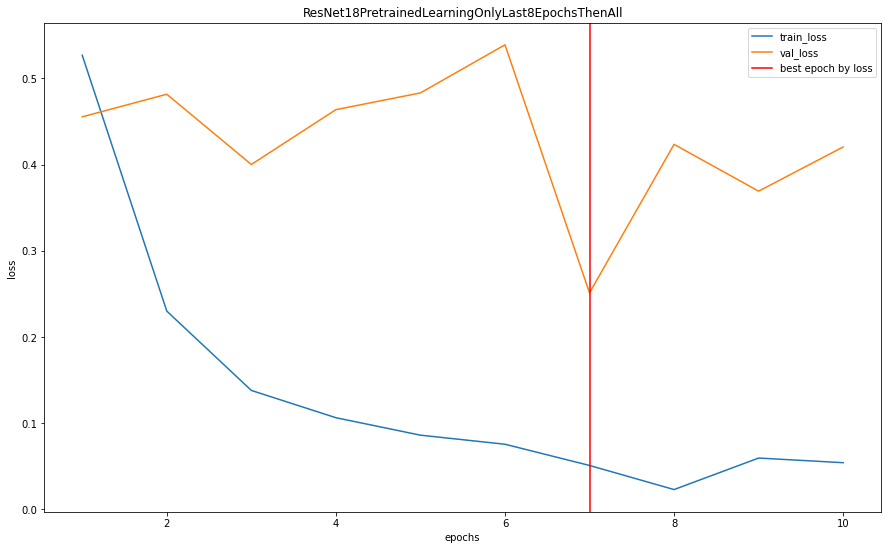

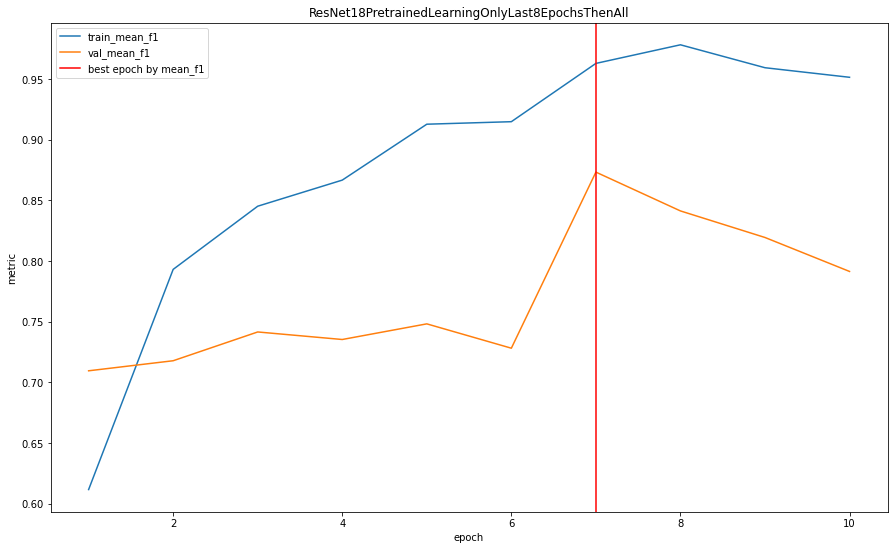

ResNet18PretrainedLearningOnlyLast8EpochsThenAll: best mean_f1 value 0.8732132864966085 on 7 epoch.


In [ ]:
state = load_model_state_and_info(
    "ResNet18PretrainedLearningOnlyLast8Epochs", TrainType.TRAIN, DEVICE)

# net = NET_CLASS()

net.load_state_dict(state['model_state'])

net.__class__.__name__ = "ResNet18PretrainedLearningOnlyLast8EpochsThenAll"


# couldn't overcome "ValueError: some parameters appear in more than one parameter group"
# previously_frozen_params = []
# for module in list(net.modules())[:-1]:
#     previously_frozen_params.extend(list(module.parameters()))
# previously_unfrozen_params = []
# for module in list(net.modules())[-1:]:
#     previously_unfrozen_params.extend(list(module.parameters()))

# optimizer  = torch.optim.Adam(previously_unfrozen_params)
# optimizer.load_state_dict(state['optimizer_state'])
# optimizer.add_param_group({'params': previously_frozen_params})

for param in net.parameters():
    param.requires_grad = True

optimizer  = torch.optim.Adam(net.parameters())

TRAIN_BATCH_SIZE = 64
EPOCHS = 10

enable_reproducibility()

torch.cuda.empty_cache()
train_loss, train_metrics, val_loss, val_metrics = train_model(
    net, train_loader, val_loader, criterion, optimizer, EPOCHS, DEVICE,
    metrics=[USED_METRIC_FUNC], save_best=True, main_metric_name=USED_METRIC_NAME)

show_plots(
    train_loss, train_metrics, val_loss, val_metrics,
    model_name=net.__class__.__name__)
print_best_epoch(
    val_metrics[USED_METRIC_NAME], metric_name=USED_METRIC_NAME,
    model_name=net.__class__.__name__)

Теперь другой вариант: так же загружаем дообученную на 8 эпохах ResNet18 (только последний слой), но затем дополнительно обучаем только последний сверточный слой:

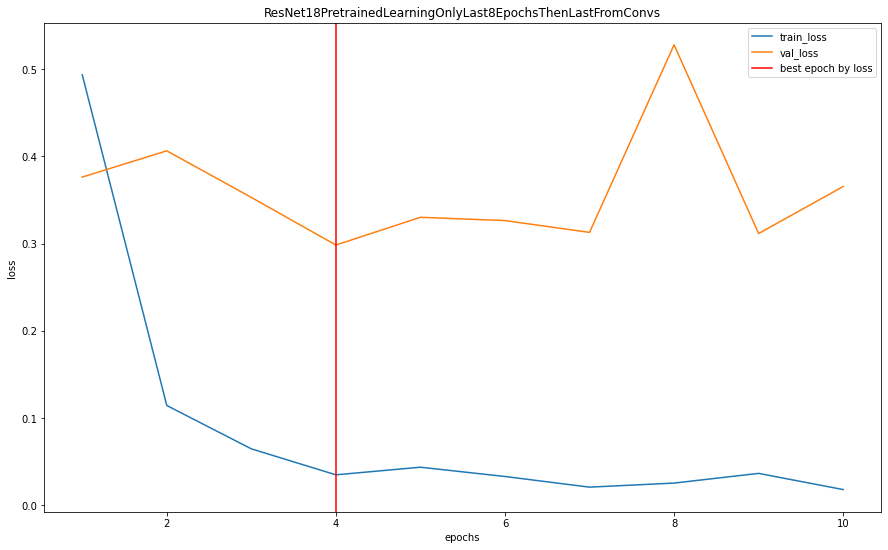

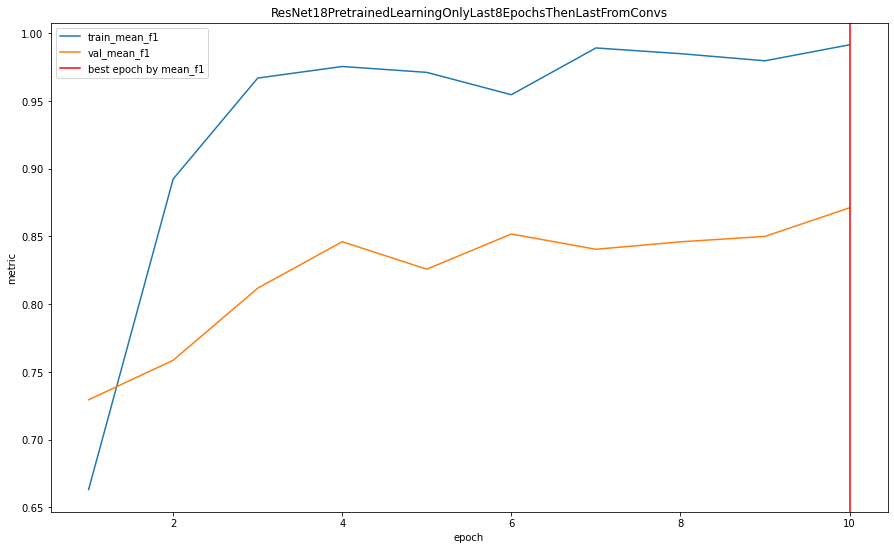

ResNet18PretrainedLearningOnlyLast8EpochsThenLastFromConvs: best mean_f1 value 0.8711864363419822 on 10 epoch.


In [ ]:
state = load_model_state_and_info(
    "ResNet18PretrainedLearningOnlyLast8Epochs", TrainType.TRAIN, DEVICE)

net.load_state_dict(state['model_state'])

net.__class__.__name__ = "ResNet18PretrainedLearningOnlyLast8EpochsThenLastFromConvs"

for param in net.parameters():
    param.requires_grad = False

from itertools import chain

for param in chain(net.layer4.parameters(), net.fc.parameters()):
    param.requires_grad = True

optimizer  = torch.optim.Adam(chain(net.layer4.parameters(), net.fc.parameters()))

TRAIN_BATCH_SIZE = 64
EPOCHS = 10

enable_reproducibility()

torch.cuda.empty_cache()
train_loss, train_metrics, val_loss, val_metrics = train_model(
    net, train_loader, val_loader, criterion, optimizer, EPOCHS, DEVICE,
    metrics=[USED_METRIC_FUNC], save_best=True, main_metric_name=USED_METRIC_NAME)

show_plots(
    train_loss, train_metrics, val_loss, val_metrics,
    model_name=net.__class__.__name__)
print_best_epoch(
    val_metrics[USED_METRIC_NAME], metric_name=USED_METRIC_NAME,
    model_name=net.__class__.__name__)

Еще вариант: теперь дообучаем два сверточных слоя.

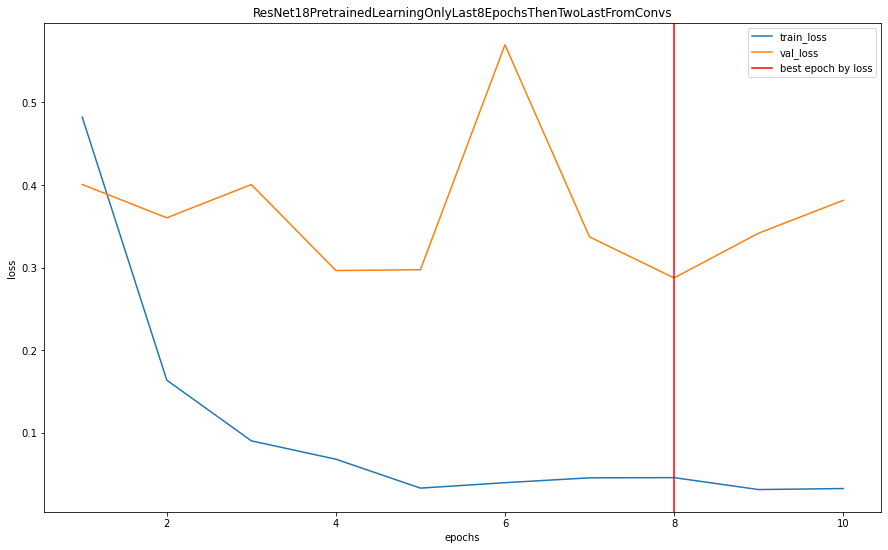

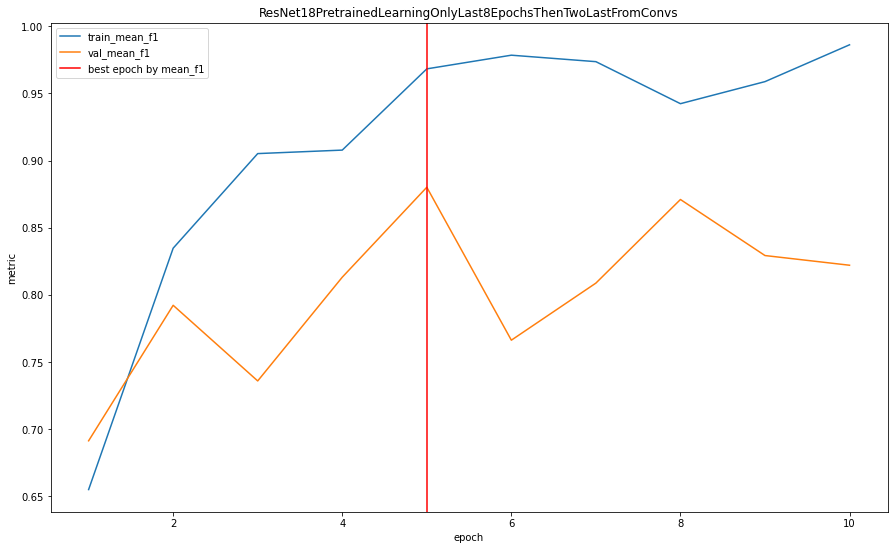

ResNet18PretrainedLearningOnlyLast8EpochsThenTwoLastFromConvs: best mean_f1 value 0.8801306398232837 on 5 epoch.


In [ ]:
state = load_model_state_and_info(
    "ResNet18PretrainedLearningOnlyLast8Epochs", TrainType.TRAIN, DEVICE)

net.load_state_dict(state['model_state'])

net.__class__.__name__ = "ResNet18PretrainedLearningOnlyLast8EpochsThenTwoLastFromConvs"

for param in net.parameters():
    param.requires_grad = False

from itertools import chain

for param in chain(net.layer3.parameters(), net.layer4.parameters(), net.fc.parameters()):
    param.requires_grad = True

optimizer  = torch.optim.Adam(chain(net.layer3.parameters(), net.layer4.parameters(), net.fc.parameters()))

TRAIN_BATCH_SIZE = 64
EPOCHS = 10

enable_reproducibility()

torch.cuda.empty_cache()
train_loss, train_metrics, val_loss, val_metrics = train_model(
    net, train_loader, val_loader, criterion, optimizer, EPOCHS, DEVICE,
    metrics=[USED_METRIC_FUNC], save_best=True, main_metric_name=USED_METRIC_NAME)

show_plots(
    train_loss, train_metrics, val_loss, val_metrics,
    model_name=net.__class__.__name__)
print_best_epoch(
    val_metrics[USED_METRIC_NAME], metric_name=USED_METRIC_NAME,
    model_name=net.__class__.__name__)

Предыдущий вариант + AdamW

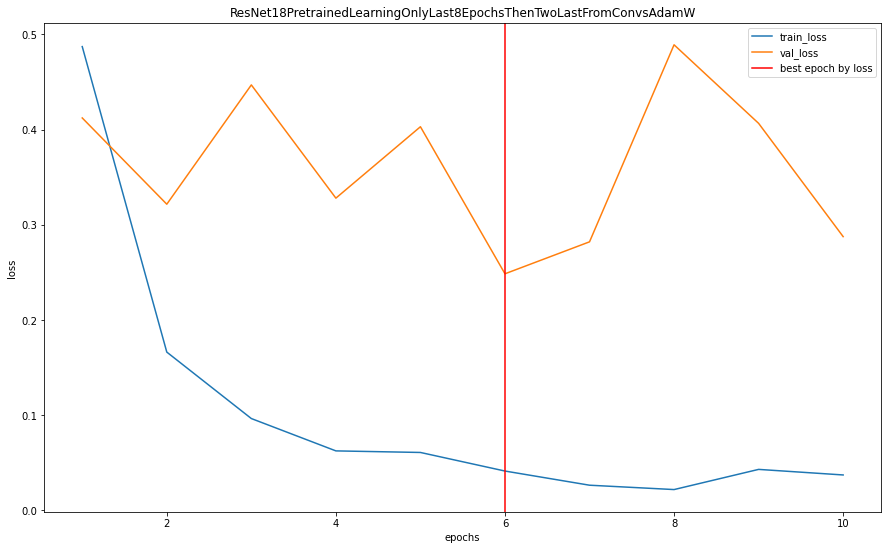

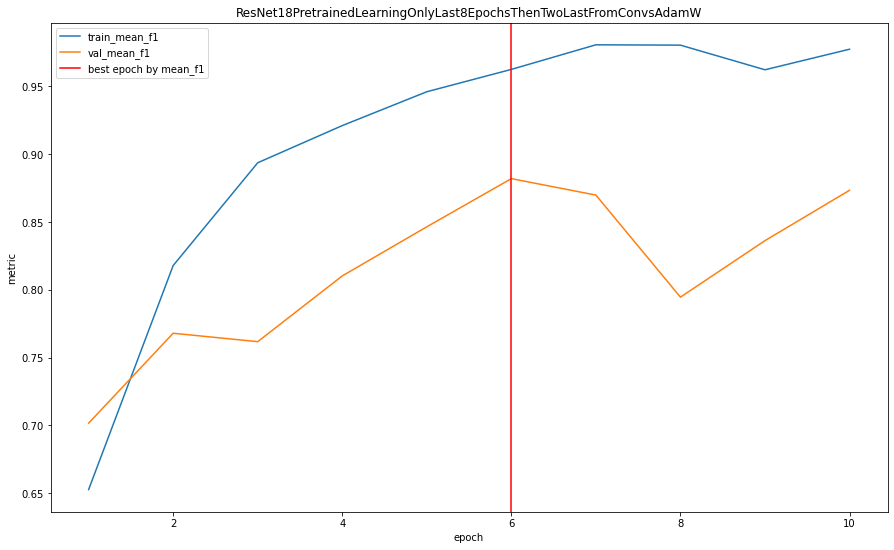

ResNet18PretrainedLearningOnlyLast8EpochsThenTwoLastFromConvsAdamW: best mean_f1 value 0.8818695265455693 on 6 epoch.


In [ ]:
state = load_model_state_and_info(
    "ResNet18PretrainedLearningOnlyLast8Epochs", TrainType.TRAIN, DEVICE)

net.load_state_dict(state['model_state'])

net.__class__.__name__ = "ResNet18PretrainedLearningOnlyLast8EpochsThenTwoLastFromConvsAdamW"

for param in net.parameters():
    param.requires_grad = False

from itertools import chain

for param in chain(net.layer3.parameters(), net.layer4.parameters(), net.fc.parameters()):
    param.requires_grad = True

optimizer  = torch.optim.AdamW(chain(net.layer3.parameters(), net.layer4.parameters(), net.fc.parameters()))

TRAIN_BATCH_SIZE = 64
EPOCHS = 10

enable_reproducibility()

torch.cuda.empty_cache()
train_loss, train_metrics, val_loss, val_metrics = train_model(
    net, train_loader, val_loader, criterion, optimizer, EPOCHS, DEVICE,
    metrics=[USED_METRIC_FUNC], save_best=True, main_metric_name=USED_METRIC_NAME)

show_plots(
    train_loss, train_metrics, val_loss, val_metrics,
    model_name=net.__class__.__name__)
print_best_epoch(
    val_metrics[USED_METRIC_NAME], metric_name=USED_METRIC_NAME,
    model_name=net.__class__.__name__)

Предыдущий вариант + AdamW + karparthy constant

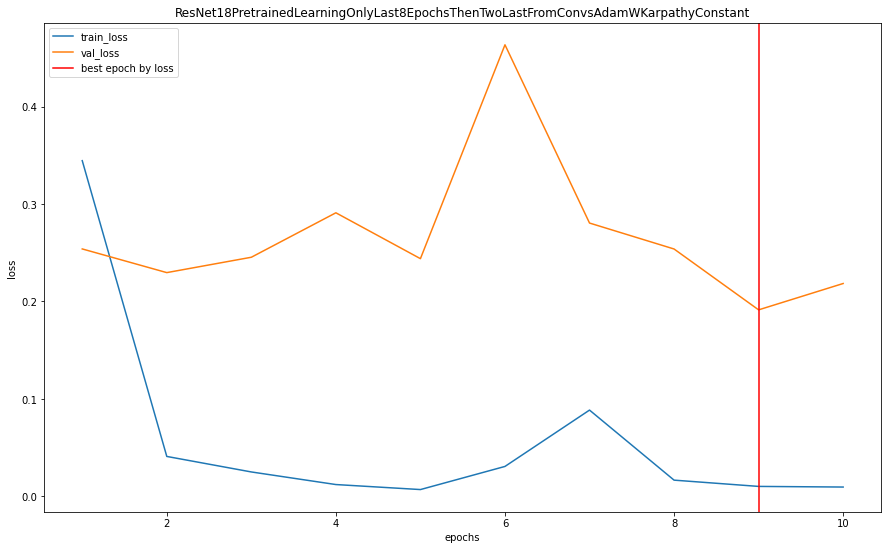

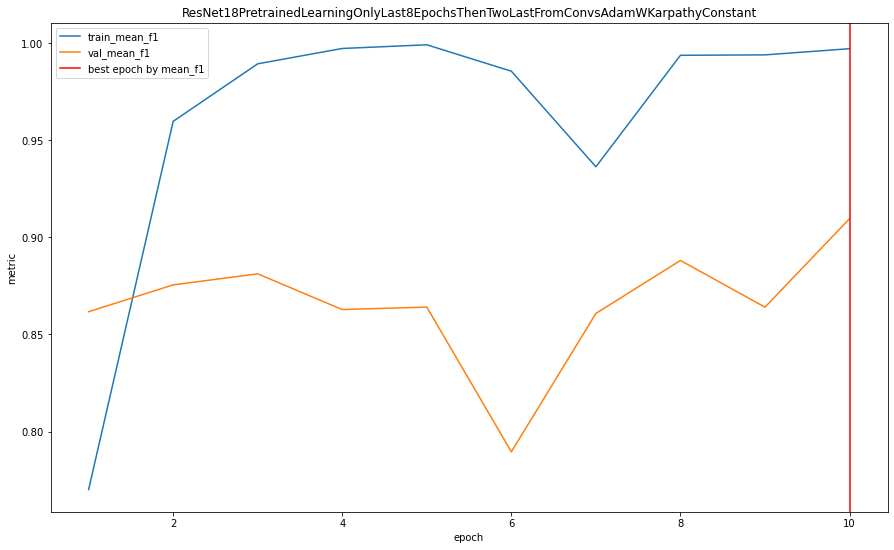

ResNet18PretrainedLearningOnlyLast8EpochsThenTwoLastFromConvsAdamWKarpathyConstant: best mean_f1 value 0.9095951926090116 on 10 epoch.


In [ ]:
state = load_model_state_and_info(
    "ResNet18PretrainedLearningOnlyLast8Epochs", TrainType.TRAIN, DEVICE)

net.load_state_dict(state['model_state'])

net.__class__.__name__ = "ResNet18PretrainedLearningOnlyLast8EpochsThenTwoLastFromConvsAdamWKarpathyConstant"

for param in net.parameters():
    param.requires_grad = False

from itertools import chain

for param in chain(net.layer3.parameters(), net.layer4.parameters(), net.fc.parameters()):
    param.requires_grad = True

optimizer  = torch.optim.AdamW(chain(net.layer3.parameters(), net.layer4.parameters(), net.fc.parameters()), lr=3e-4)

TRAIN_BATCH_SIZE = 64
EPOCHS = 10

enable_reproducibility()

torch.cuda.empty_cache()
train_loss, train_metrics, val_loss, val_metrics = train_model(
    net, train_loader, val_loader, criterion, optimizer, EPOCHS, DEVICE,
    metrics=[USED_METRIC_FUNC], save_best=True, main_metric_name=USED_METRIC_NAME)

show_plots(
    train_loss, train_metrics, val_loss, val_metrics,
    model_name=net.__class__.__name__)
print_best_epoch(
    val_metrics[USED_METRIC_NAME], metric_name=USED_METRIC_NAME,
    model_name=net.__class__.__name__)

# #3 submit with ResNet18PretrainedLearningOnlyLast8EpochsThenTwoLastFromConvsAdamWKarpathyConstant learned on full dataset (10 epochs)
Попробуем засабмитить предыдущую модель.

ResNet18PretrainedLearningOnlyLast8Epochs(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


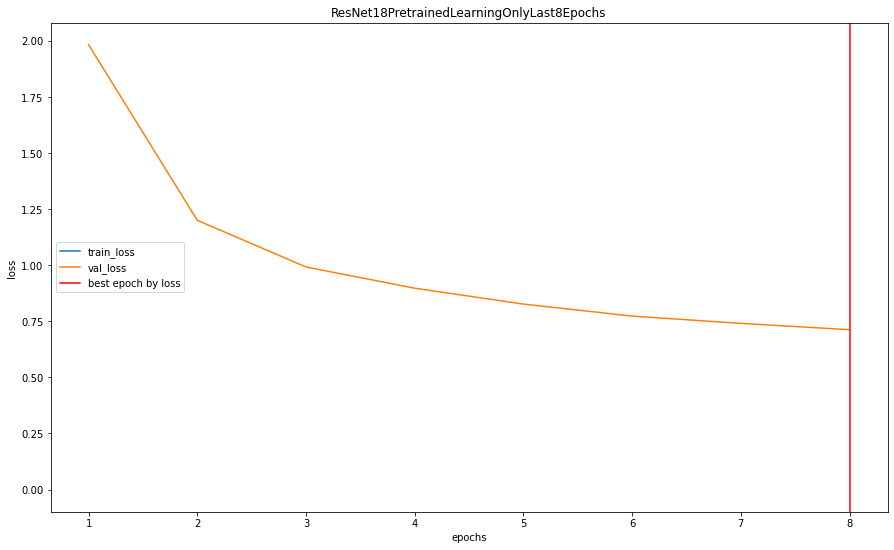

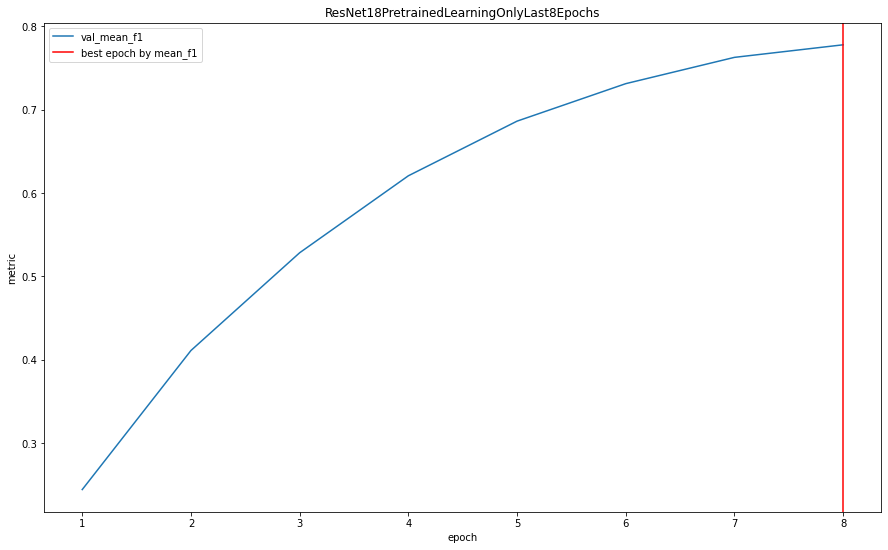

ResNet18PretrainedLearningOnlyLast8Epochs: best mean_f1 value 0.7777648528733678 on 8 epoch.


In [ ]:
net = torchvision.models.resnet18(pretrained=True)

# замораживаем параметры (веса)
for param in net.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 512
# Заменяем Fully-Connected слой на наш линейный классификатор
enable_reproducibility()
net.fc = nn.Linear(num_features, CLASSES_NUM)

# Обучаем только классификатор
optimizer = torch.optim.Adam(net.fc.parameters())
NET_CLASS = net.__class__
NET_CLASS.__name__ = 'ResNet18PretrainedLearningOnlyLast8Epochs'

train_transform = val_transform = default_transform
train_dataset = ImageClassDirectoriesDataset(
    train_files, mode='train', labels=label_encoder, transform=train_transform)
val_dataset = ImageClassDirectoriesDataset(
    val_files, mode='val', labels=label_encoder, transform=val_transform)

train_transform = val_transform = default_transform
train_val_dataset = ImageClassDirectoriesDataset(
    train_val_files, mode='train', labels=label_encoder, transform=train_transform)

TRAIN_BATCH_SIZE = 64
EPOCHS = 8

enable_reproducibility()
train_val_loader = DataLoader(
    train_val_dataset, batch_size=TRAIN_BATCH_SIZE,
    shuffle=True, num_workers=NUM_WORKERS)

criterion = nn.CrossEntropyLoss()

torch.cuda.empty_cache()
# net = NET_CLASS(CLASSES_NUM).to(DEVICE)
net = net.to(DEVICE)
# optimizer = torch.optim.Adam(net.parameters())
print(net)

train_loss, train_metrics = refit(
    net, train_val_loader, criterion, optimizer, EPOCHS, DEVICE,
    metrics=[USED_METRIC_FUNC], save_best=True, main_metric_name=USED_METRIC_NAME)

show_plots(
    [0], {}, train_loss, train_metrics,
    model_name=net.__class__.__name__)
print_best_epoch(
    train_metrics[USED_METRIC_NAME], metric_name=USED_METRIC_NAME,
    model_name=net.__class__.__name__)

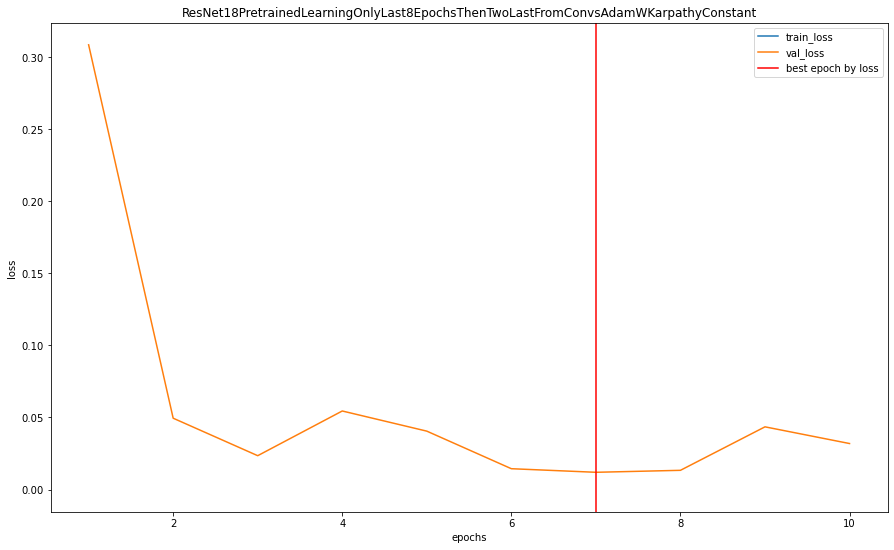

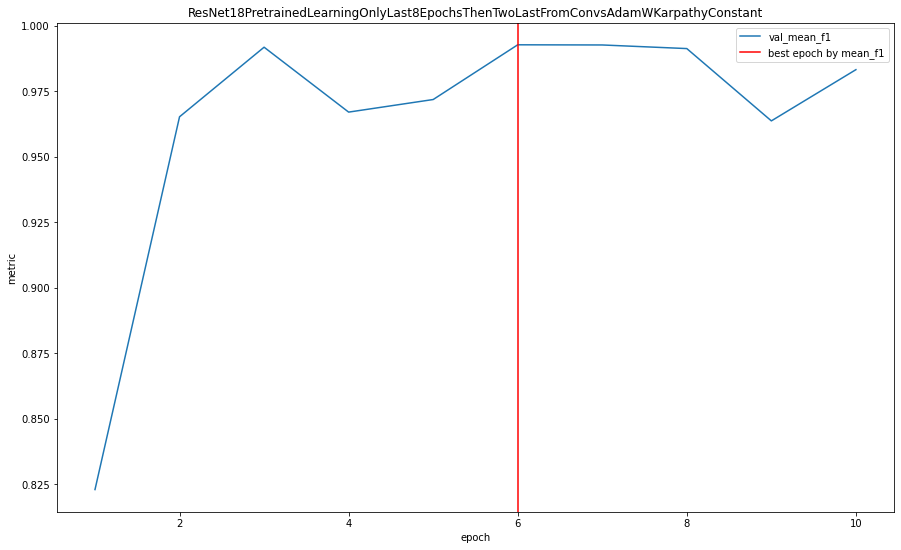

ResNet18PretrainedLearningOnlyLast8EpochsThenTwoLastFromConvsAdamWKarpathyConstant: best mean_f1 value 0.9926525844871208 on 6 epoch.


In [ ]:
state = load_model_state_and_info(
    "ResNet18PretrainedLearningOnlyLast8Epochs", TrainType.FULL, DEVICE)

net.load_state_dict(state['model_state'])

net.__class__.__name__ = "ResNet18PretrainedLearningOnlyLast8EpochsThenTwoLastFromConvsAdamWKarpathyConstant"

for param in net.parameters():
    param.requires_grad = False

from itertools import chain

for param in chain(net.layer3.parameters(), net.layer4.parameters(), net.fc.parameters()):
    param.requires_grad = True

optimizer  = torch.optim.AdamW(chain(net.layer3.parameters(), net.layer4.parameters(), net.fc.parameters()), lr=3e-4)

TRAIN_BATCH_SIZE = 64
EPOCHS = 10

enable_reproducibility()

torch.cuda.empty_cache()
train_loss, train_metrics = refit(
    net, train_val_loader, criterion, optimizer, EPOCHS, DEVICE,
    metrics=[USED_METRIC_FUNC], save_best=True, main_metric_name=USED_METRIC_NAME)

show_plots(
    [0], {}, train_loss, train_metrics,
    model_name=net.__class__.__name__)
print_best_epoch(
    train_metrics[USED_METRIC_NAME], metric_name=USED_METRIC_NAME,
    model_name=net.__class__.__name__)

In [ ]:
enable_reproducibility()
test_dataset = ImageClassDirectoriesDataset(
    test_files, mode='test', labels=label_encoder, transform=default_transform)
test_loader = DataLoader(
    test_dataset, batch_size=TEST_BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS)

torch.cuda.empty_cache()
samples_ids, labels, probs = predict_unknown(net, test_loader, DEVICE)
save_results(samples_ids, labels, label_encoder, "ResNet18PretrainedLearningOnlyLast8EpochsThenTwoLastFromConvsAdamWKarpathyConstant_full_10_epochs.csv")

На Кагле скор 0.99574.